In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [11]:
SEQ_LEN = 128
W, H = 40, 40

stateful_pong_generator = pong.StatefulPongGenerator(W, H, SEQ_LEN, stochasticity=0.85)

def data_input():
    for (d, c), (f, g) in stateful_pong_generator:
        yield (np.array([np.sin(d), np.cos(d)]), c), (f,)

dataset = tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32,)),
)

make_dataset = lambda bs: dataset.batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

# make_dataset = lambda bs: tf.data.Dataset.range(10_000).interleave(
#     lambda _: dataset.batch(bs),
#     num_parallel_calls=tf.data.experimental.AUTOTUNE,
#     cycle_length=32
# )

In [12]:
list(make_dataset(10).take(5))[0][0][1].shape

TensorShape([Dimension(10), Dimension(128), Dimension(2)])

In [131]:
class Model:
    INTERNAL_SIZE = 48

    def project_game_init(self, init_x):
        self.project_state = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_activation',
            activation='relu'
        )

        return self.project_state(init_x)

    def rollout(self, initial_state, user_input):
        self.gru = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru',
            activation='tanh'
        )
        self.lstm = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru1.5',
            activation='relu'
        )
        self.gru2 = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru2',
            activation='relu'
        )
        x = self.gru(user_input, initial_state=initial_state)
        x = self.lstm(x)
        x = self.gru2(x)

        return x

    def render(self, memory):
        self.renderer = tf.keras.layers.Dense(W * H, activation='sigmoid', name='frame_matrix')
        self.reshaper = tf.keras.layers.Reshape((-1, W, H), name='frame_vector')

        return self.reshaper(self.renderer(memory))

    def __init__(self):
        game_init = tf.keras.layers.Input(shape=(2), name='game_init')
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input')

        initial_state = self.project_game_init(game_init)
        rollout_memory = self.rollout(initial_state, user_input)
        frame = self.render(rollout_memory)

        self.net = tf.keras.Model([game_init, user_input], [frame])

        initial_learning_rate = 0.002
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.9,
#             staircase=True
        )
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

        self.net.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['mse', 'accuracy']
        )

In [132]:
model = Model()
model.net.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 48)           144         game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 48)     7344        user_input[0][0]                 
                                                                 project_activation[0][0]  

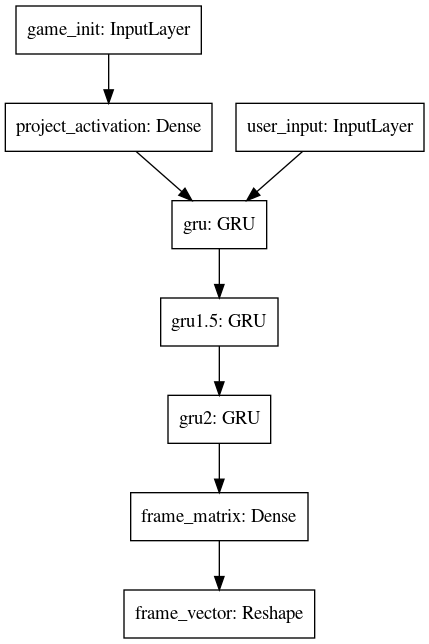

In [133]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [134]:
frame_nums = [2, 4, 8, 16, 32, 64, 127]

def plot_pairwise_frames():
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames,) = X, Y
    pred_frames = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0, w_pad=0, h_pad=0)

class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames()
        plt.show()

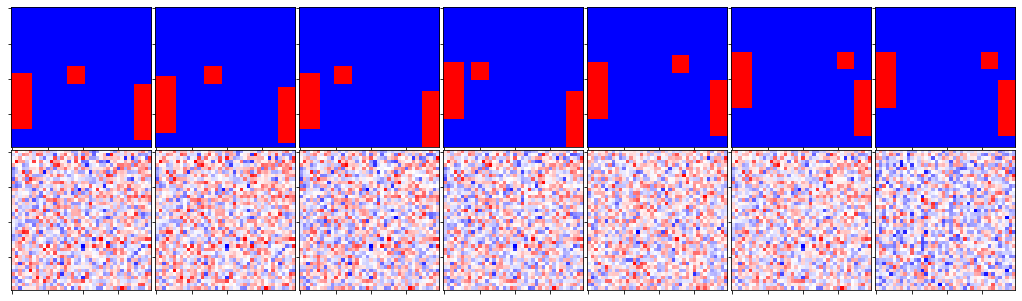

Epoch 1/2500
100/100 [==============================] - 93s 934ms/step - loss: 0.2772 - mean_squared_error: 0.0846 - acc: 0.9257 - val_loss: 0.1851 - val_mean_squared_error: 0.0514 - val_acc: 0.9322


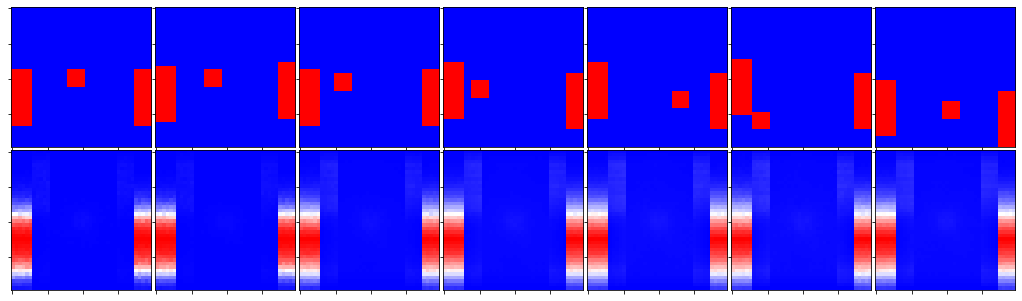

Epoch 2/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.1711 - mean_squared_error: 0.0472 - acc: 0.9384 - val_loss: 0.1614 - val_mean_squared_error: 0.0442 - val_acc: 0.9427


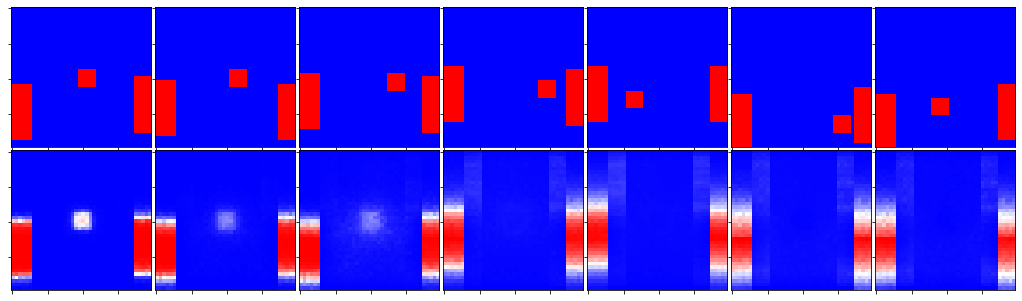

Epoch 3/2500
100/100 [==============================] - 84s 835ms/step - loss: 0.1552 - mean_squared_error: 0.0424 - acc: 0.9450 - val_loss: 0.1503 - val_mean_squared_error: 0.0405 - val_acc: 0.9482


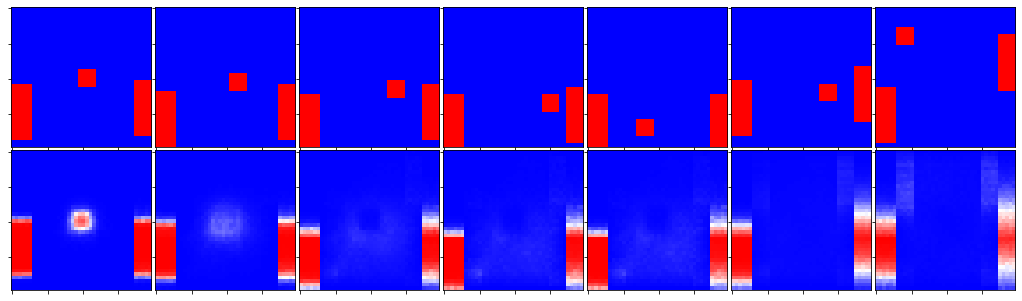

Epoch 4/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1433 - mean_squared_error: 0.0386 - acc: 0.9506 - val_loss: 0.1370 - val_mean_squared_error: 0.0363 - val_acc: 0.9540


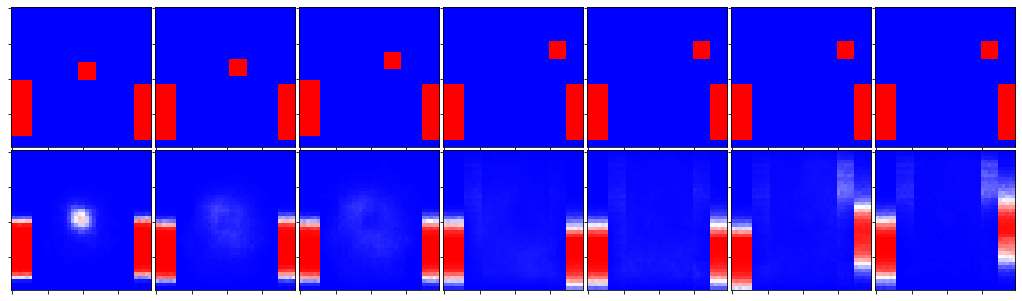

Epoch 5/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1321 - mean_squared_error: 0.0353 - acc: 0.9551 - val_loss: 0.1238 - val_mean_squared_error: 0.0327 - val_acc: 0.9589


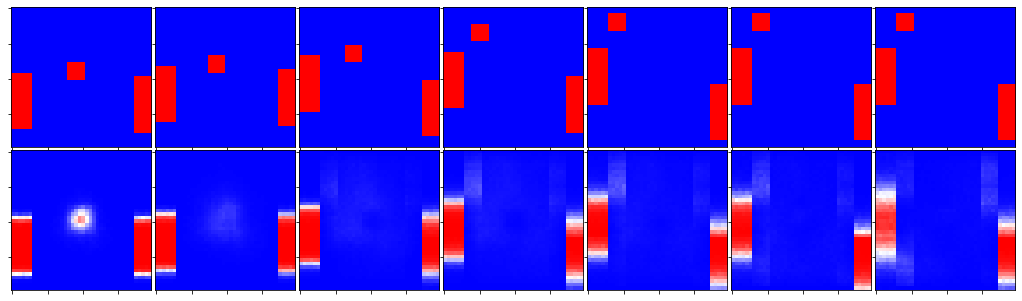

Epoch 6/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.1232 - mean_squared_error: 0.0328 - acc: 0.9586 - val_loss: 0.1220 - val_mean_squared_error: 0.0320 - val_acc: 0.9604


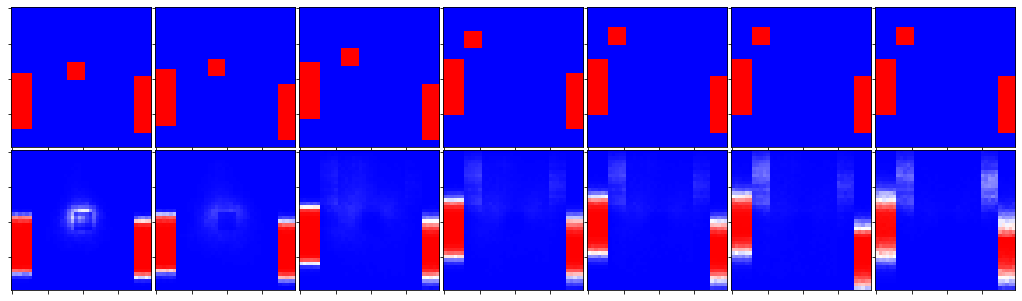

Epoch 7/2500
100/100 [==============================] - 83s 831ms/step - loss: 0.1160 - mean_squared_error: 0.0308 - acc: 0.9613 - val_loss: 0.1153 - val_mean_squared_error: 0.0307 - val_acc: 0.9617


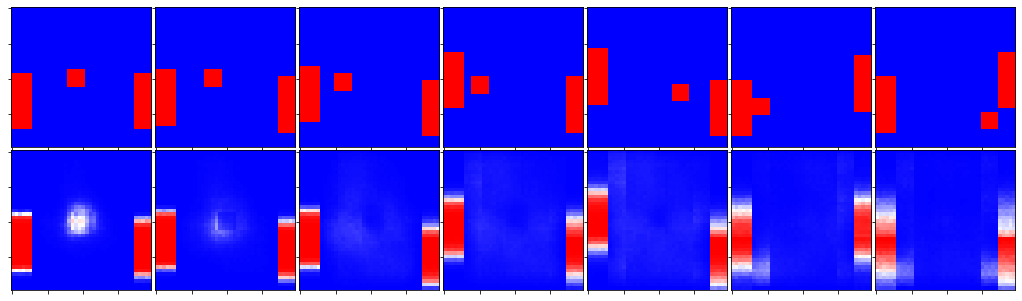

Epoch 8/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.1130 - mean_squared_error: 0.0300 - acc: 0.9622 - val_loss: 0.1130 - val_mean_squared_error: 0.0301 - val_acc: 0.9622


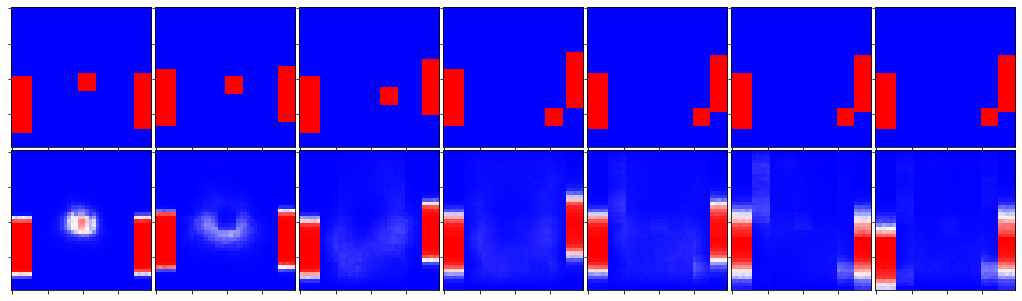

Epoch 9/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.1106 - mean_squared_error: 0.0295 - acc: 0.9628 - val_loss: 0.1126 - val_mean_squared_error: 0.0305 - val_acc: 0.9611


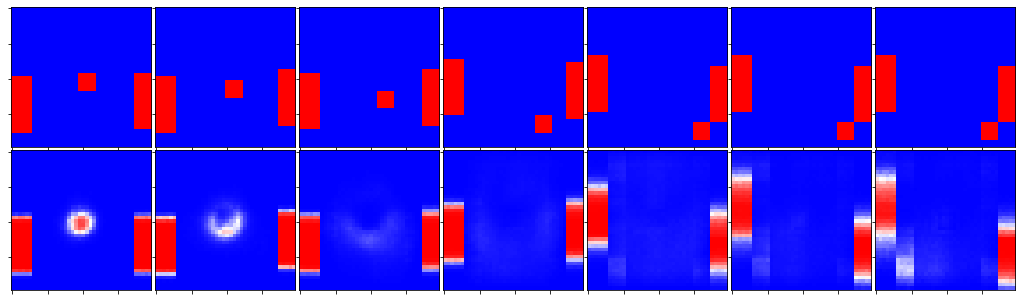

Epoch 10/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.1086 - mean_squared_error: 0.0289 - acc: 0.9634 - val_loss: 0.1114 - val_mean_squared_error: 0.0297 - val_acc: 0.9623


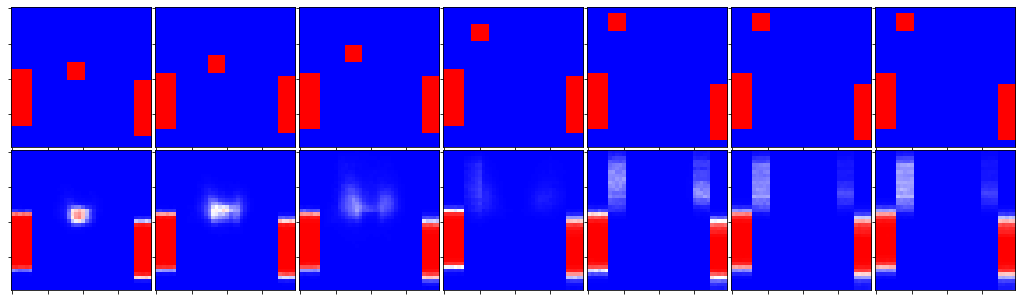

Epoch 11/2500
100/100 [==============================] - 83s 835ms/step - loss: 0.1082 - mean_squared_error: 0.0288 - acc: 0.9634 - val_loss: 0.1065 - val_mean_squared_error: 0.0282 - val_acc: 0.9643


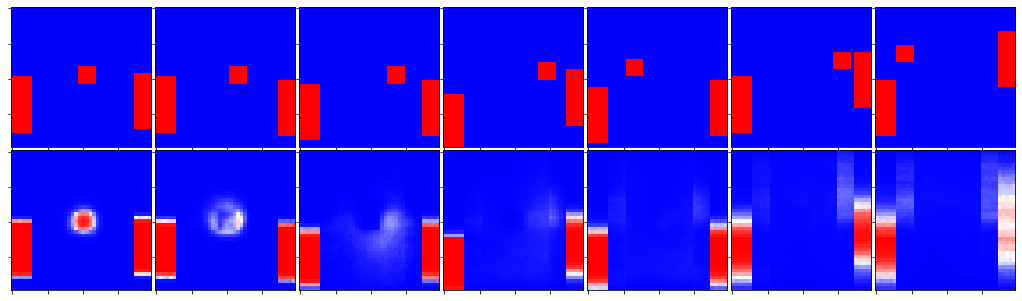

Epoch 12/2500
100/100 [==============================] - 83s 834ms/step - loss: 0.1049 - mean_squared_error: 0.0280 - acc: 0.9643 - val_loss: 0.1088 - val_mean_squared_error: 0.0289 - val_acc: 0.9635


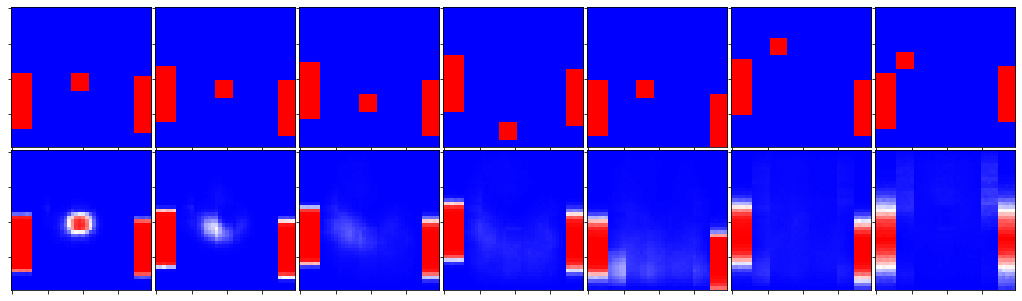

Epoch 13/2500
100/100 [==============================] - 84s 837ms/step - loss: 0.1044 - mean_squared_error: 0.0279 - acc: 0.9645 - val_loss: 0.1054 - val_mean_squared_error: 0.0283 - val_acc: 0.9637


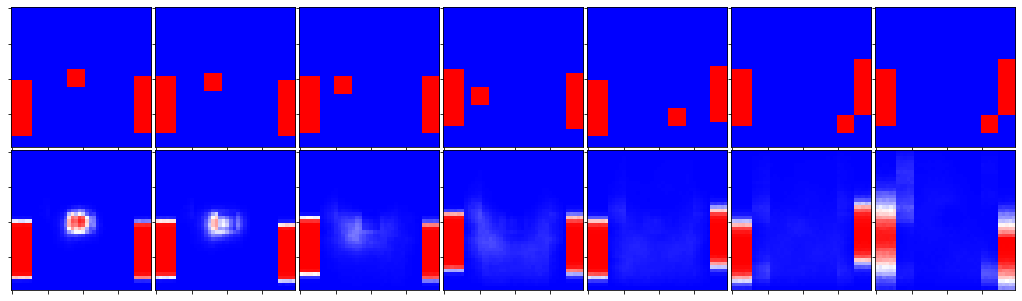

Epoch 14/2500
100/100 [==============================] - 84s 835ms/step - loss: 0.1021 - mean_squared_error: 0.0272 - acc: 0.9654 - val_loss: 0.1077 - val_mean_squared_error: 0.0290 - val_acc: 0.9631


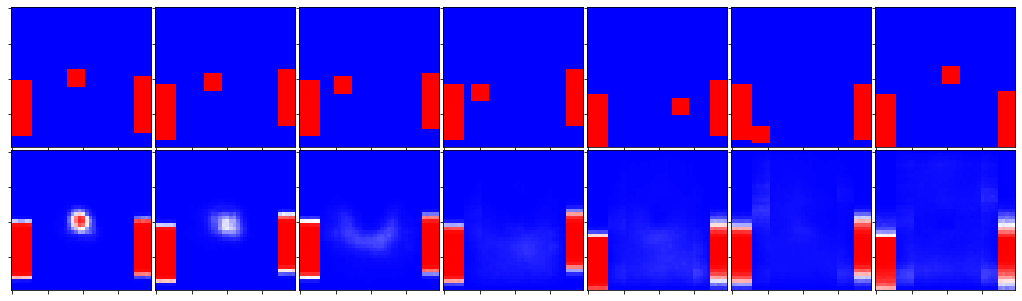

Epoch 15/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.1019 - mean_squared_error: 0.0272 - acc: 0.9653 - val_loss: 0.0933 - val_mean_squared_error: 0.0249 - val_acc: 0.9680


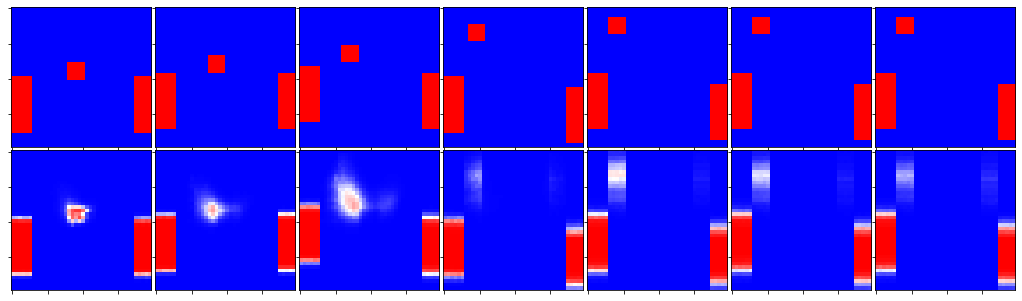

Epoch 16/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.1000 - mean_squared_error: 0.0268 - acc: 0.9657 - val_loss: 0.0969 - val_mean_squared_error: 0.0263 - val_acc: 0.9656


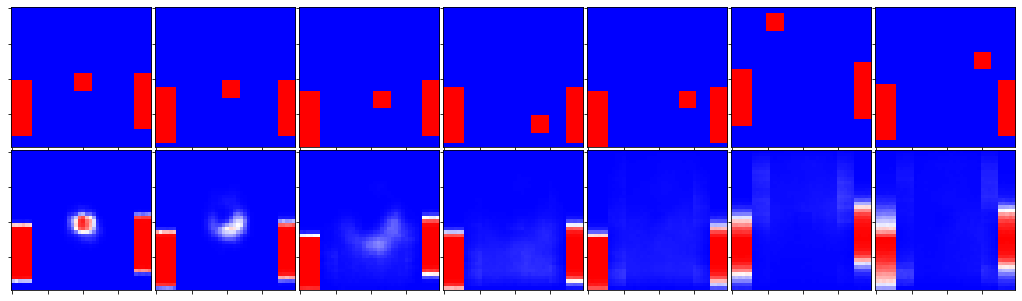

Epoch 17/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0982 - mean_squared_error: 0.0261 - acc: 0.9666 - val_loss: 0.0935 - val_mean_squared_error: 0.0254 - val_acc: 0.9666


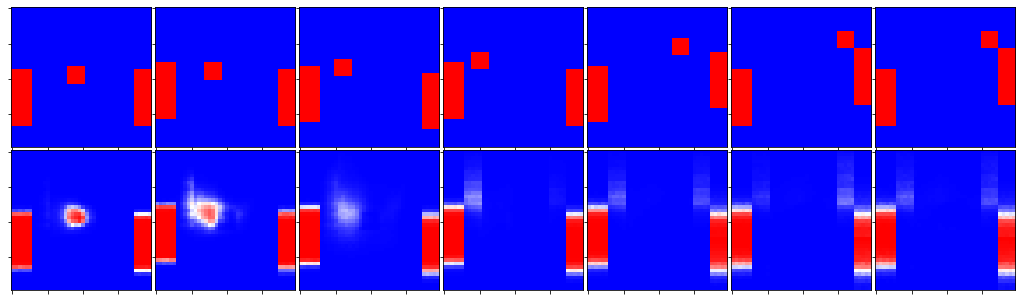

Epoch 18/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0974 - mean_squared_error: 0.0259 - acc: 0.9670 - val_loss: 0.0966 - val_mean_squared_error: 0.0252 - val_acc: 0.9683


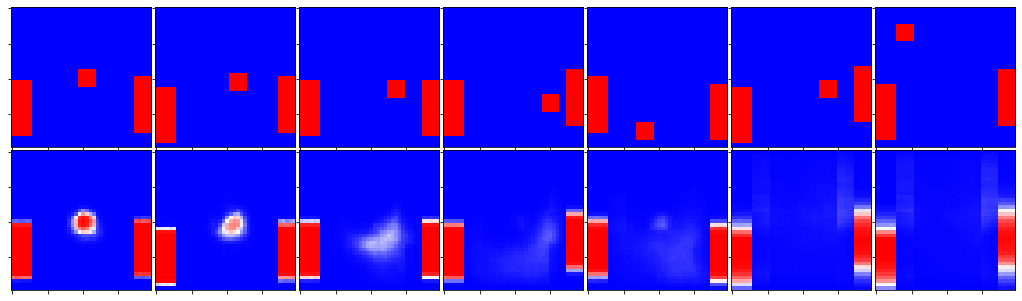

Epoch 19/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0966 - mean_squared_error: 0.0257 - acc: 0.9671 - val_loss: 0.0959 - val_mean_squared_error: 0.0252 - val_acc: 0.9684


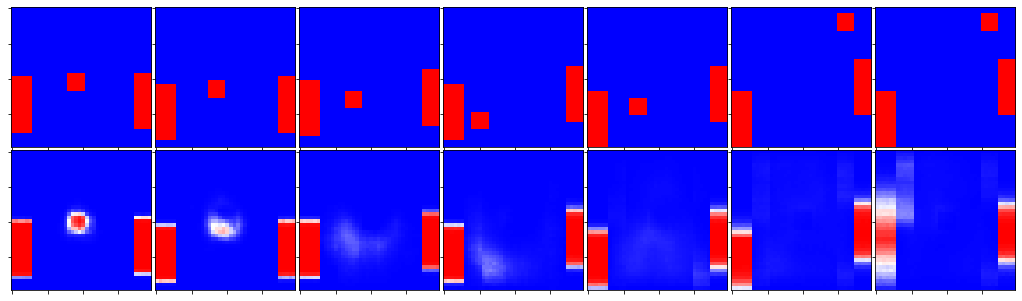

Epoch 20/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0956 - mean_squared_error: 0.0255 - acc: 0.9674 - val_loss: 0.0959 - val_mean_squared_error: 0.0257 - val_acc: 0.9667


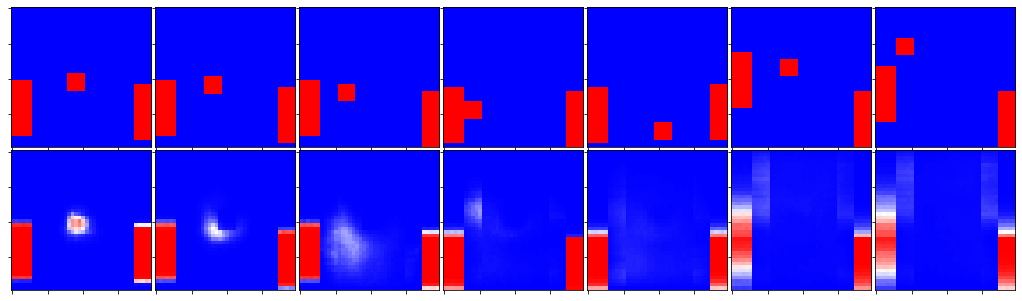

Epoch 21/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0948 - mean_squared_error: 0.0253 - acc: 0.9676 - val_loss: 0.0983 - val_mean_squared_error: 0.0261 - val_acc: 0.9665


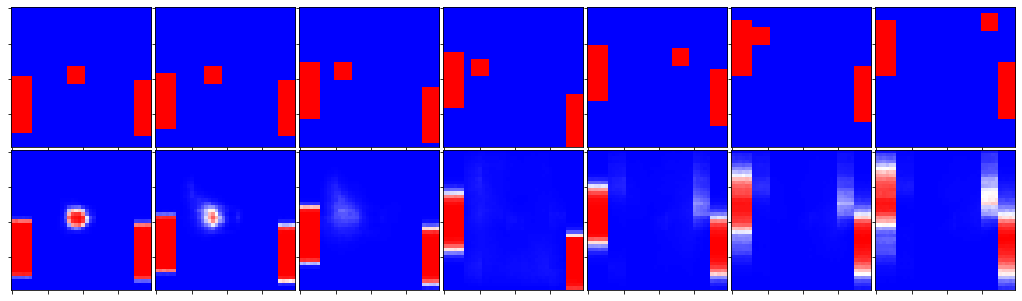

Epoch 22/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0937 - mean_squared_error: 0.0251 - acc: 0.9678 - val_loss: 0.0927 - val_mean_squared_error: 0.0246 - val_acc: 0.9687


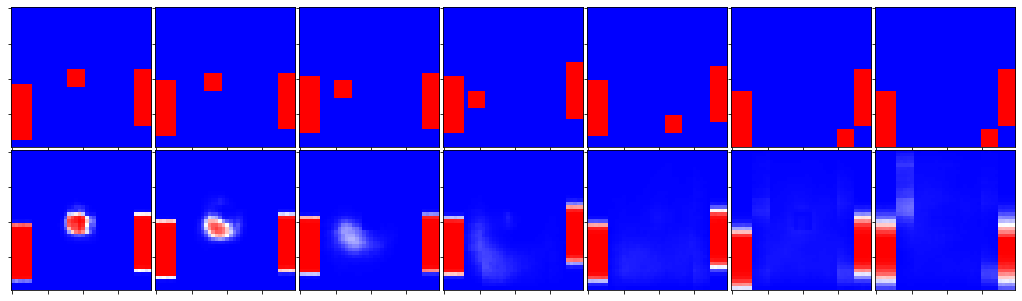

Epoch 23/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0934 - mean_squared_error: 0.0250 - acc: 0.9679 - val_loss: 0.0947 - val_mean_squared_error: 0.0253 - val_acc: 0.9679


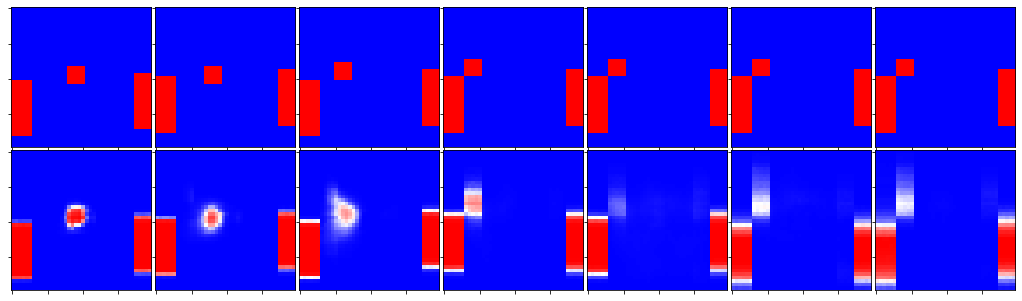

Epoch 24/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0917 - mean_squared_error: 0.0244 - acc: 0.9689 - val_loss: 0.0976 - val_mean_squared_error: 0.0260 - val_acc: 0.9665


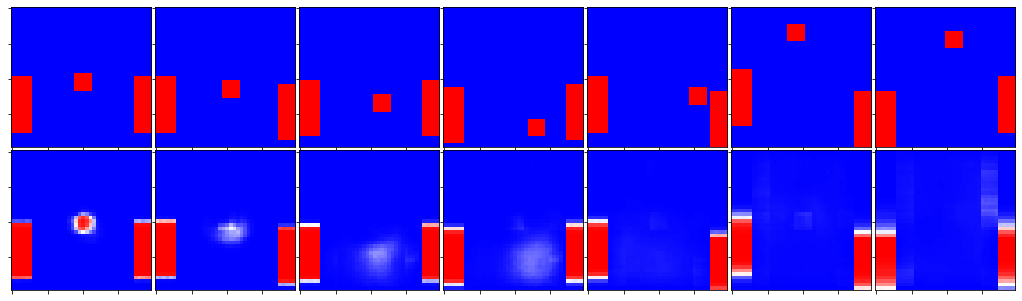

Epoch 25/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0904 - mean_squared_error: 0.0242 - acc: 0.9691 - val_loss: 0.0926 - val_mean_squared_error: 0.0248 - val_acc: 0.9680


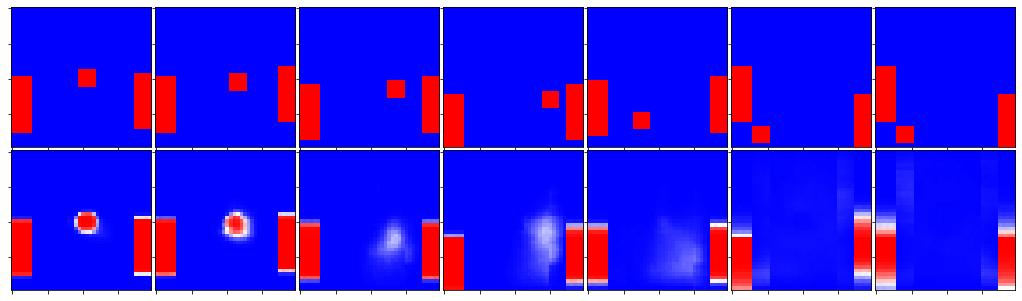

Epoch 26/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0897 - mean_squared_error: 0.0240 - acc: 0.9694 - val_loss: 0.1027 - val_mean_squared_error: 0.0280 - val_acc: 0.9637


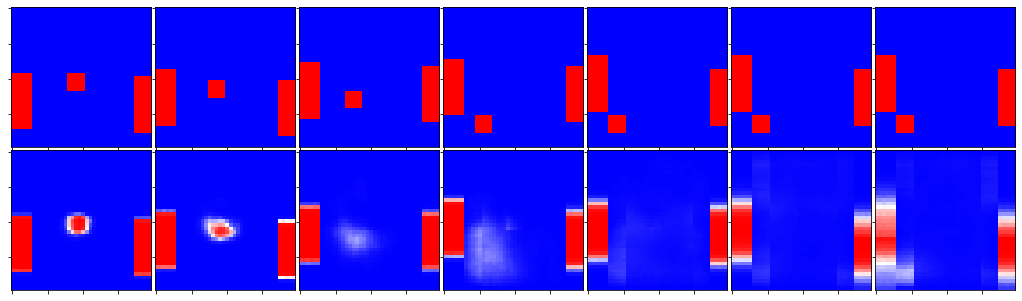

Epoch 27/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0895 - mean_squared_error: 0.0240 - acc: 0.9692 - val_loss: 0.0897 - val_mean_squared_error: 0.0241 - val_acc: 0.9692


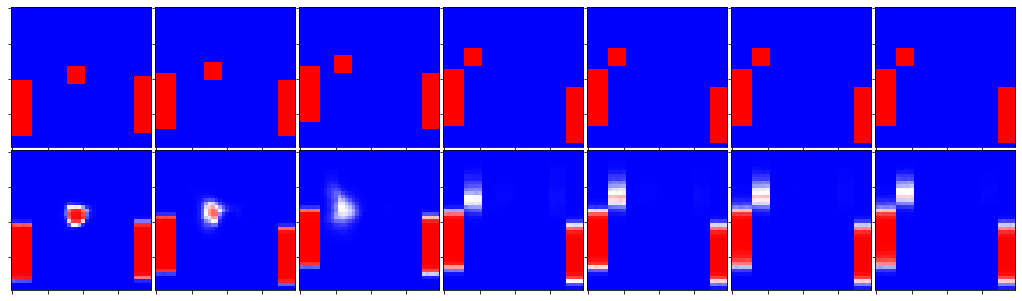

Epoch 28/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0888 - mean_squared_error: 0.0237 - acc: 0.9697 - val_loss: 0.0916 - val_mean_squared_error: 0.0244 - val_acc: 0.9690


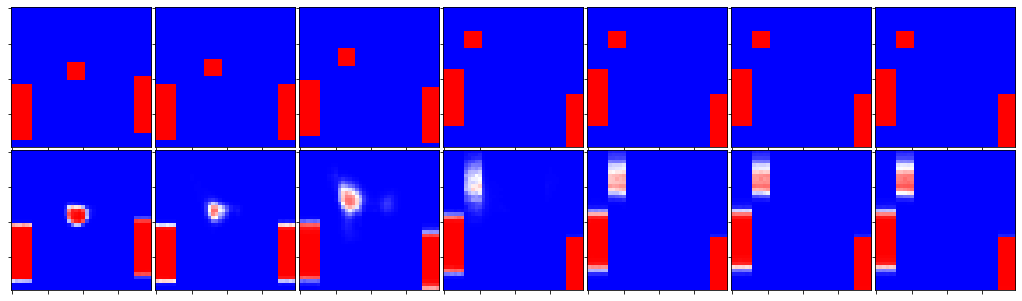

Epoch 29/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0886 - mean_squared_error: 0.0236 - acc: 0.9700 - val_loss: 0.0880 - val_mean_squared_error: 0.0233 - val_acc: 0.9704


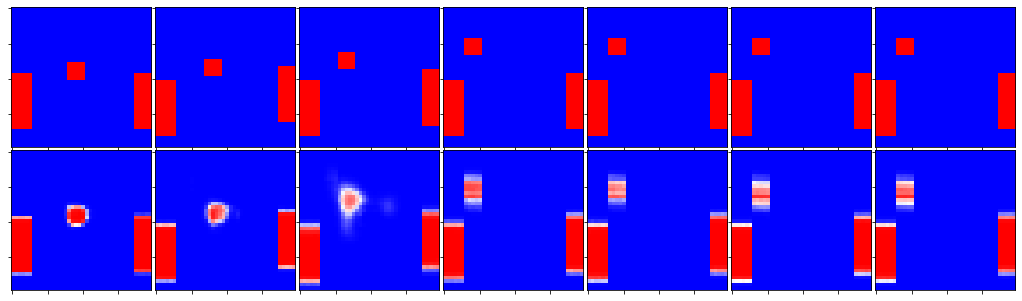

Epoch 30/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0870 - mean_squared_error: 0.0233 - acc: 0.9702 - val_loss: 0.0810 - val_mean_squared_error: 0.0220 - val_acc: 0.9717


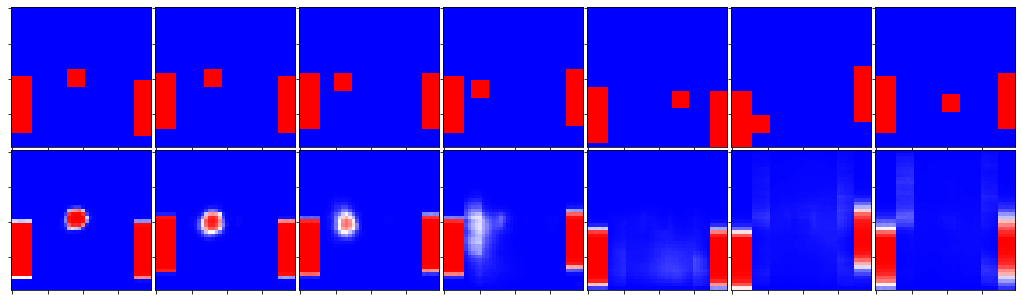

Epoch 31/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0867 - mean_squared_error: 0.0233 - acc: 0.9703 - val_loss: 0.0875 - val_mean_squared_error: 0.0235 - val_acc: 0.9698


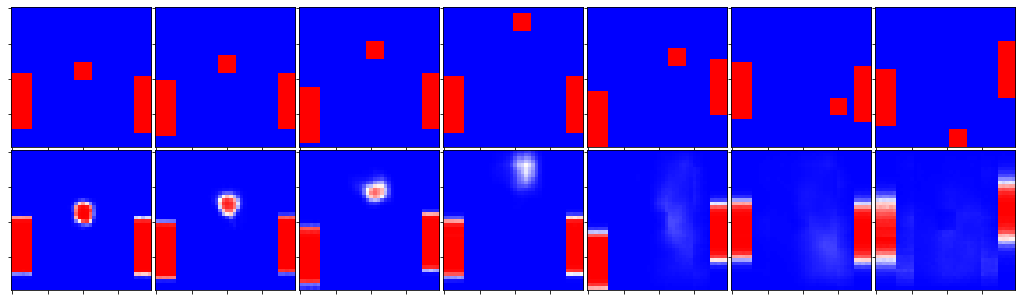

Epoch 32/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0870 - mean_squared_error: 0.0234 - acc: 0.9701 - val_loss: 0.0853 - val_mean_squared_error: 0.0227 - val_acc: 0.9711


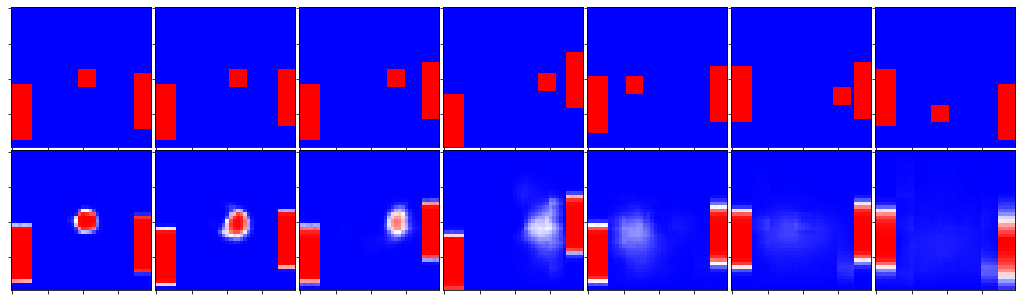

Epoch 33/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0855 - mean_squared_error: 0.0229 - acc: 0.9708 - val_loss: 0.0851 - val_mean_squared_error: 0.0231 - val_acc: 0.9701


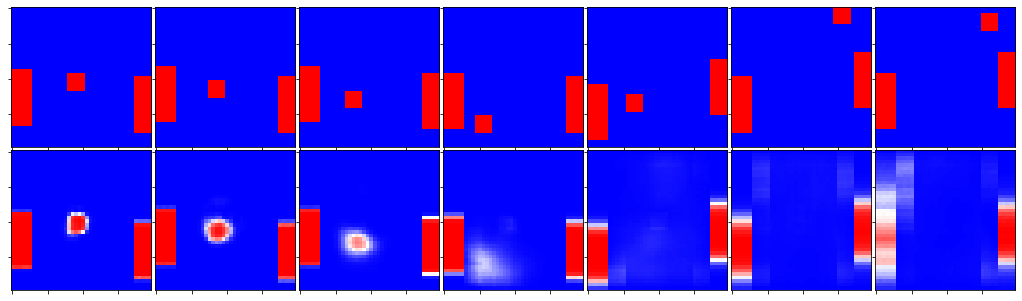

Epoch 34/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0875 - mean_squared_error: 0.0235 - acc: 0.9699 - val_loss: 0.0881 - val_mean_squared_error: 0.0242 - val_acc: 0.9688


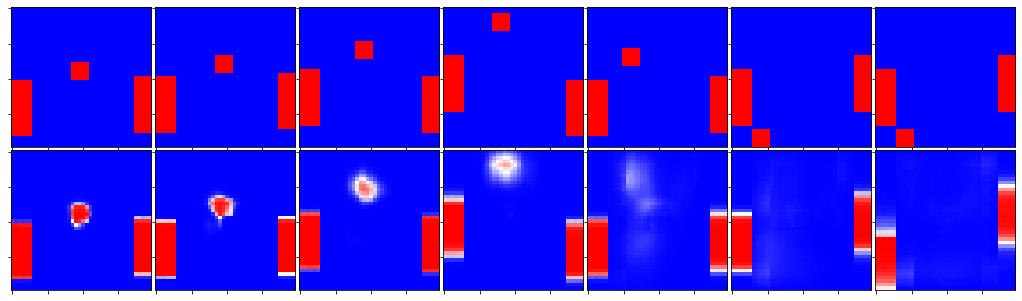

Epoch 35/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0841 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0869 - val_mean_squared_error: 0.0232 - val_acc: 0.9709


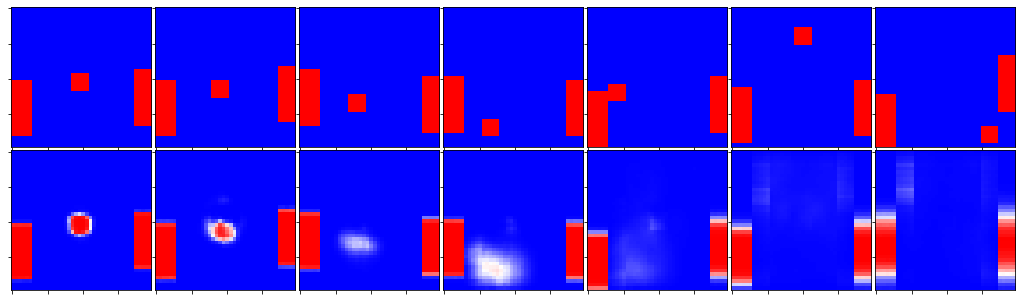

Epoch 36/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0830 - mean_squared_error: 0.0222 - acc: 0.9717 - val_loss: 0.0814 - val_mean_squared_error: 0.0220 - val_acc: 0.9716


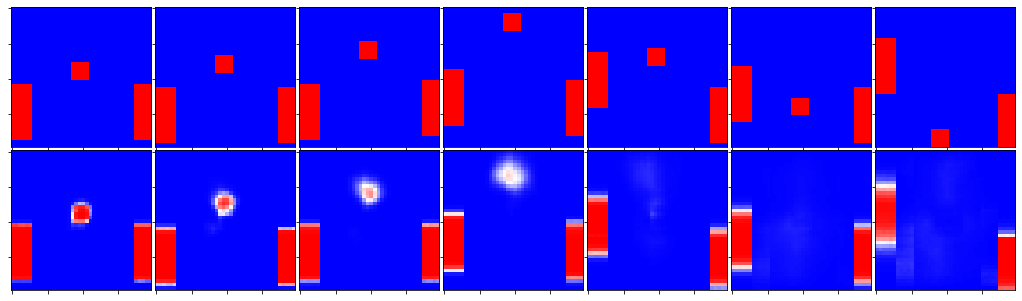

Epoch 37/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0833 - mean_squared_error: 0.0223 - acc: 0.9717 - val_loss: 0.0809 - val_mean_squared_error: 0.0222 - val_acc: 0.9716


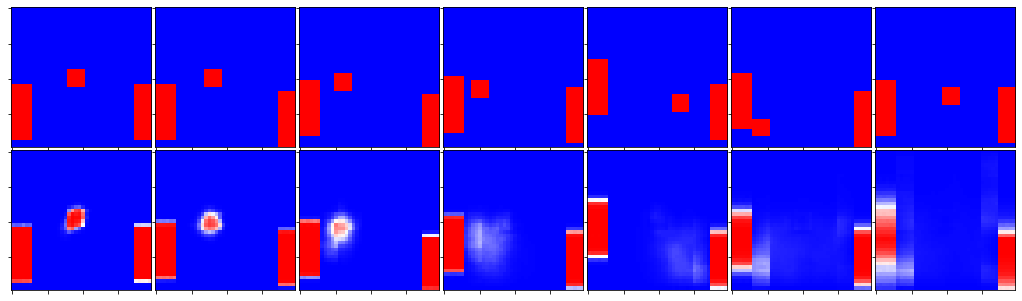

Epoch 38/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0830 - mean_squared_error: 0.0223 - acc: 0.9717 - val_loss: 0.0854 - val_mean_squared_error: 0.0230 - val_acc: 0.9708


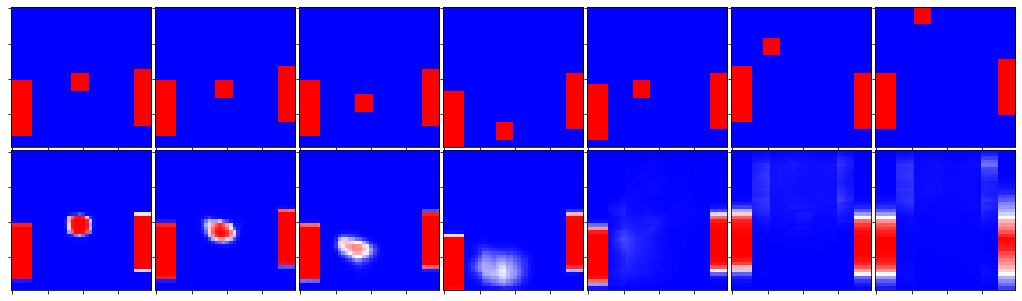

Epoch 39/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0835 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0894 - val_mean_squared_error: 0.0244 - val_acc: 0.9687


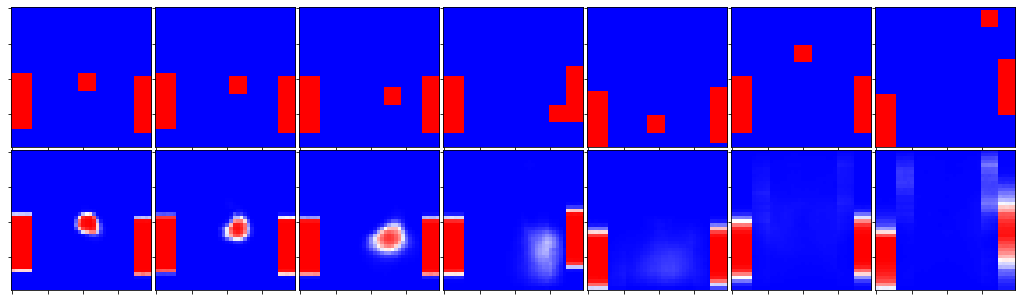

Epoch 40/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0825 - mean_squared_error: 0.0223 - acc: 0.9715 - val_loss: 0.0903 - val_mean_squared_error: 0.0237 - val_acc: 0.9697


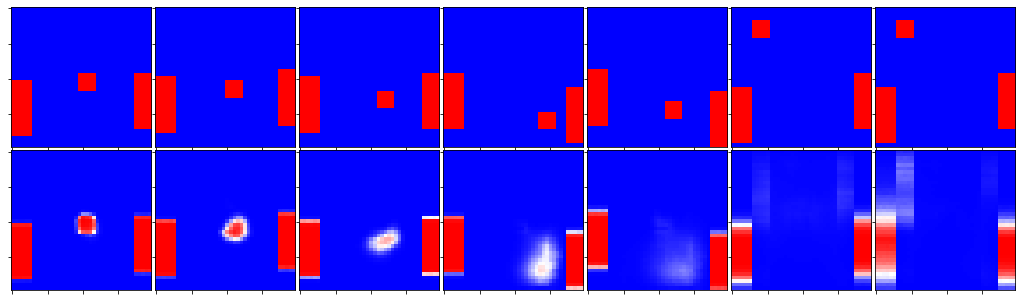

Epoch 41/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0825 - mean_squared_error: 0.0222 - acc: 0.9717 - val_loss: 0.0845 - val_mean_squared_error: 0.0225 - val_acc: 0.9717


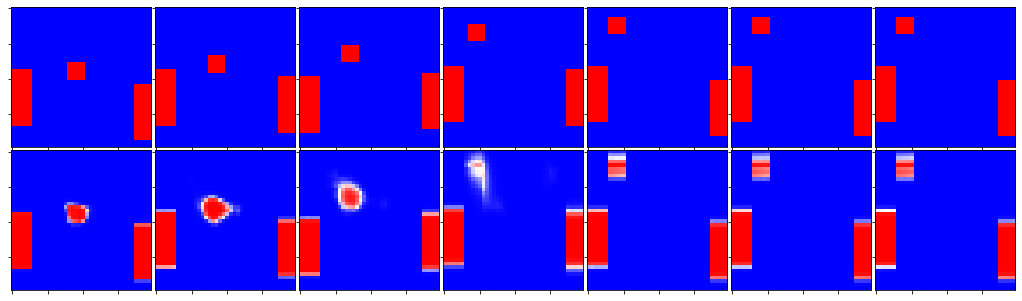

Epoch 42/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0834 - mean_squared_error: 0.0225 - acc: 0.9713 - val_loss: 0.0833 - val_mean_squared_error: 0.0227 - val_acc: 0.9705


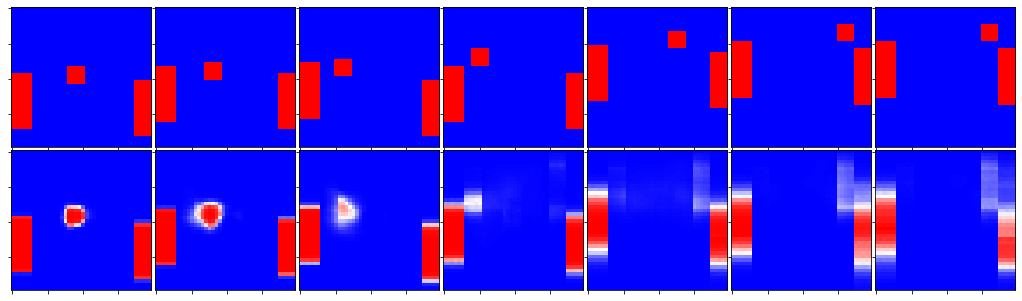

Epoch 43/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0798 - mean_squared_error: 0.0215 - acc: 0.9727 - val_loss: 0.0756 - val_mean_squared_error: 0.0208 - val_acc: 0.9734


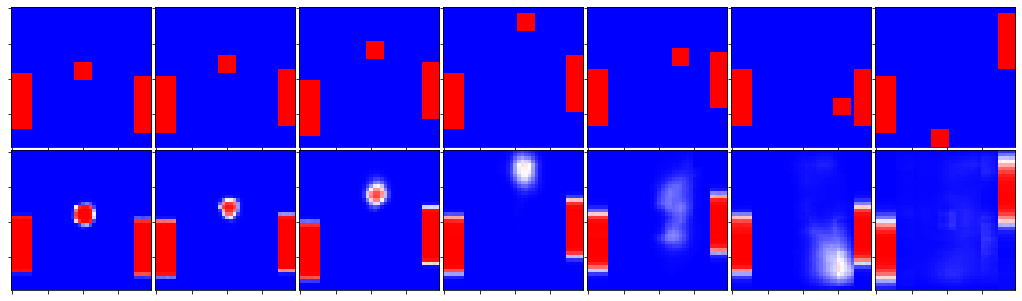

Epoch 44/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0804 - mean_squared_error: 0.0218 - acc: 0.9721 - val_loss: 0.0779 - val_mean_squared_error: 0.0206 - val_acc: 0.9740


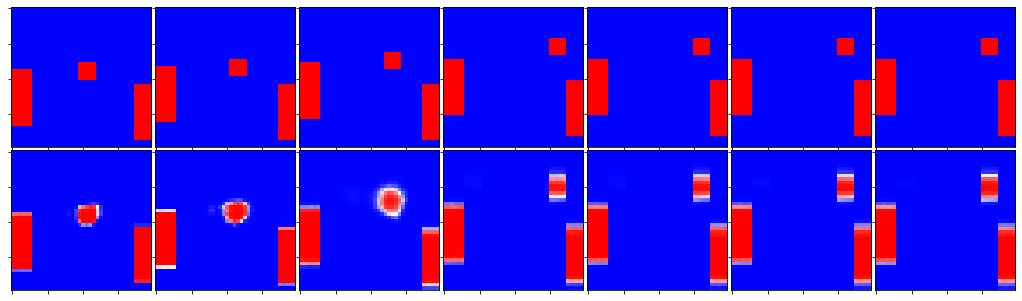

Epoch 45/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0785 - mean_squared_error: 0.0212 - acc: 0.9729 - val_loss: 0.0824 - val_mean_squared_error: 0.0225 - val_acc: 0.9712


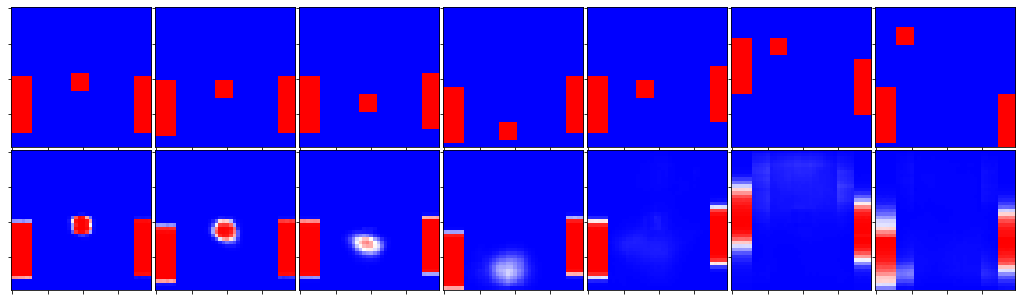

Epoch 46/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0782 - mean_squared_error: 0.0212 - acc: 0.9729 - val_loss: 0.0877 - val_mean_squared_error: 0.0239 - val_acc: 0.9696


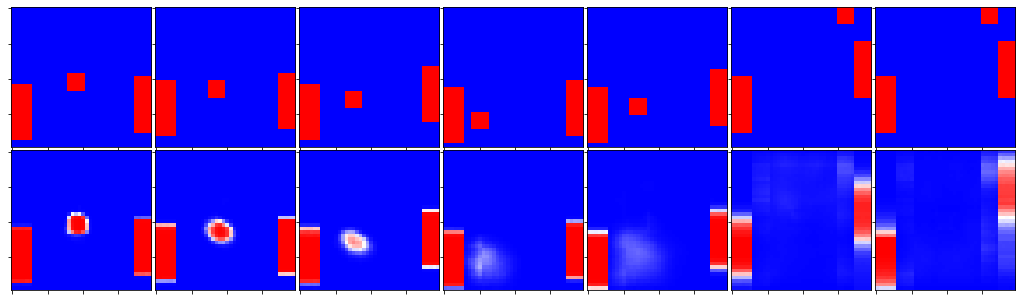

Epoch 47/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0780 - mean_squared_error: 0.0211 - acc: 0.9730 - val_loss: 0.0721 - val_mean_squared_error: 0.0197 - val_acc: 0.9748


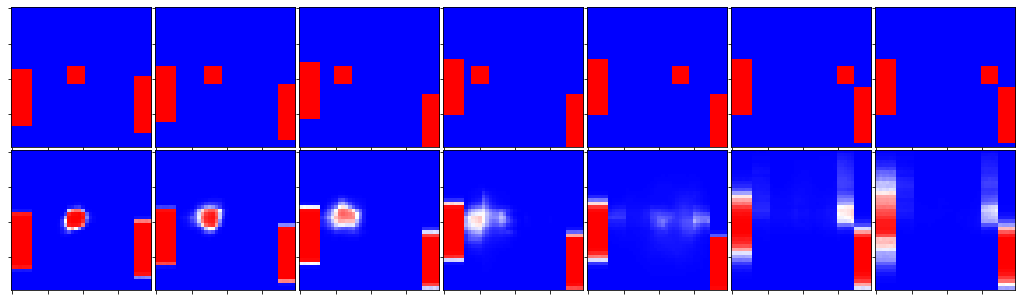

Epoch 48/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0774 - mean_squared_error: 0.0211 - acc: 0.9730 - val_loss: 0.0795 - val_mean_squared_error: 0.0219 - val_acc: 0.9721


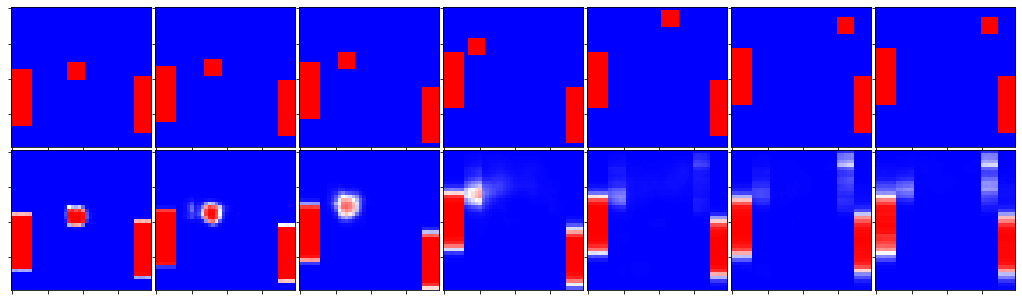

Epoch 49/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0779 - mean_squared_error: 0.0212 - acc: 0.9728 - val_loss: 0.0752 - val_mean_squared_error: 0.0203 - val_acc: 0.9740


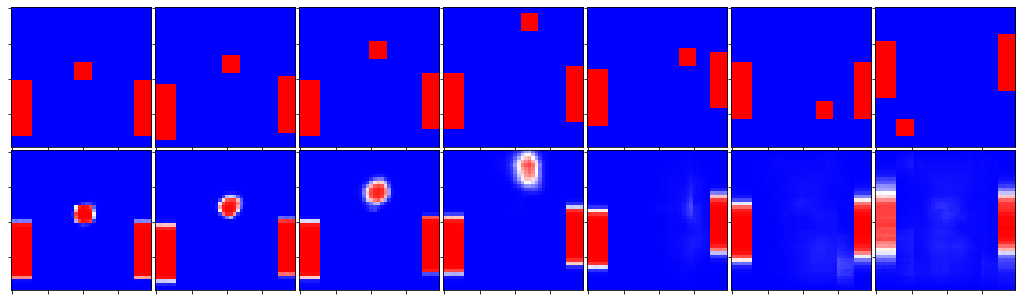

Epoch 50/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0761 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0709 - val_mean_squared_error: 0.0191 - val_acc: 0.9756


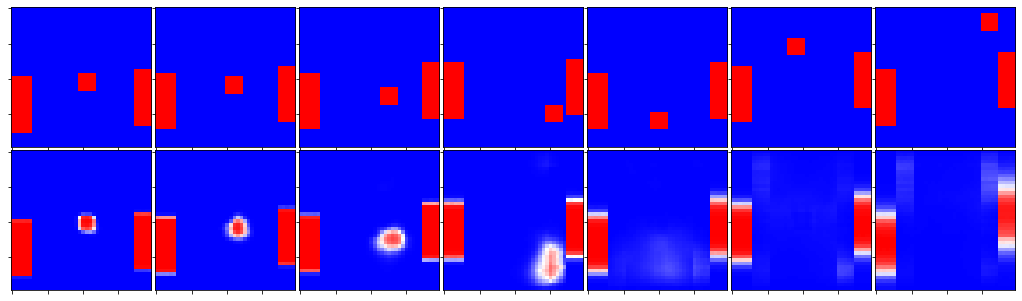

Epoch 51/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0762 - mean_squared_error: 0.0207 - acc: 0.9736 - val_loss: 0.0713 - val_mean_squared_error: 0.0195 - val_acc: 0.9752


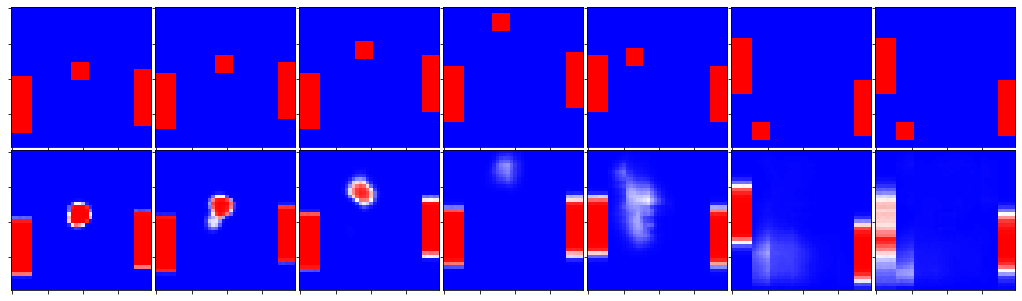

Epoch 52/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0760 - mean_squared_error: 0.0206 - acc: 0.9737 - val_loss: 0.0731 - val_mean_squared_error: 0.0198 - val_acc: 0.9748


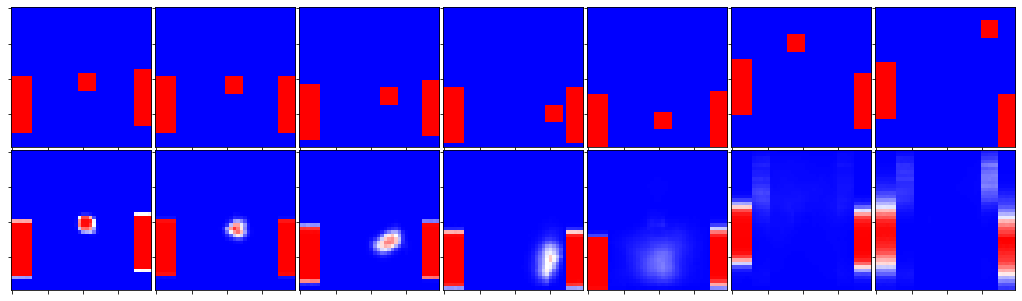

Epoch 53/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0754 - mean_squared_error: 0.0206 - acc: 0.9736 - val_loss: 0.0764 - val_mean_squared_error: 0.0211 - val_acc: 0.9726


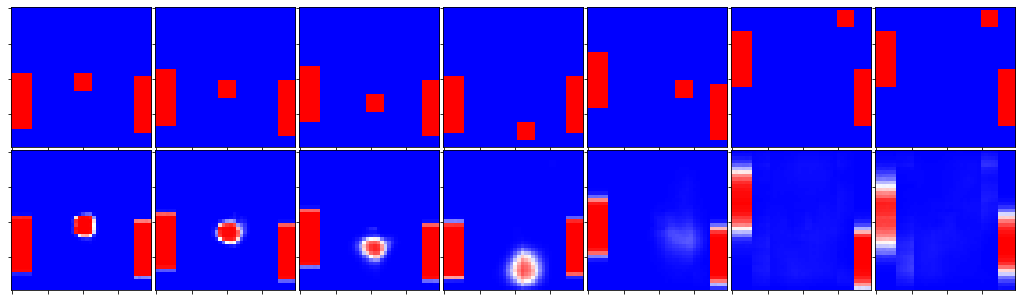

Epoch 54/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0747 - mean_squared_error: 0.0204 - acc: 0.9740 - val_loss: 0.0790 - val_mean_squared_error: 0.0215 - val_acc: 0.9725


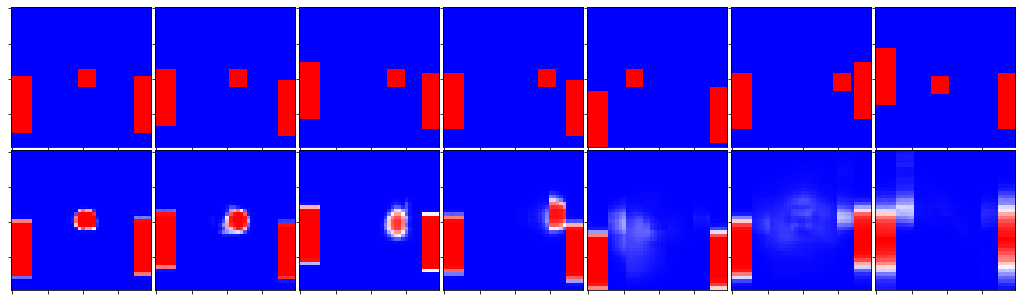

Epoch 55/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0747 - mean_squared_error: 0.0205 - acc: 0.9736 - val_loss: 0.0818 - val_mean_squared_error: 0.0231 - val_acc: 0.9696


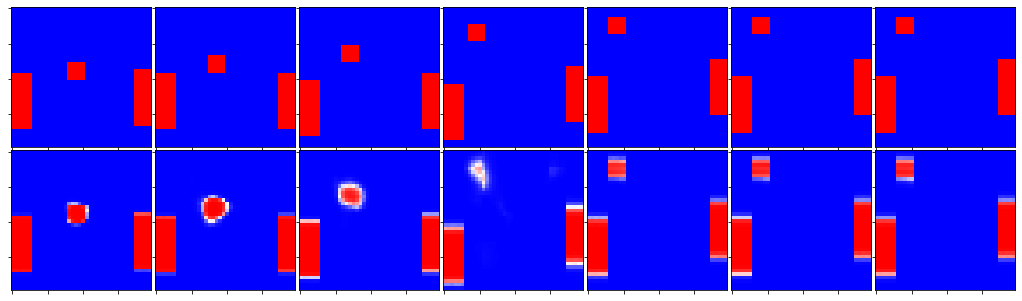

Epoch 56/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0741 - mean_squared_error: 0.0203 - acc: 0.9741 - val_loss: 0.0723 - val_mean_squared_error: 0.0202 - val_acc: 0.9739


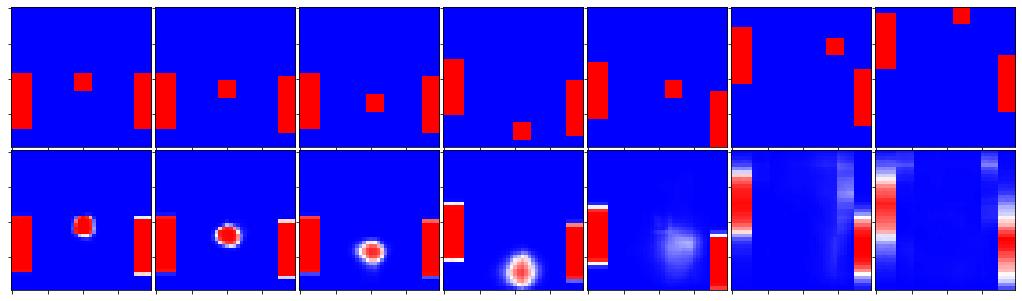

Epoch 57/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0729 - mean_squared_error: 0.0201 - acc: 0.9741 - val_loss: 0.0743 - val_mean_squared_error: 0.0206 - val_acc: 0.9731


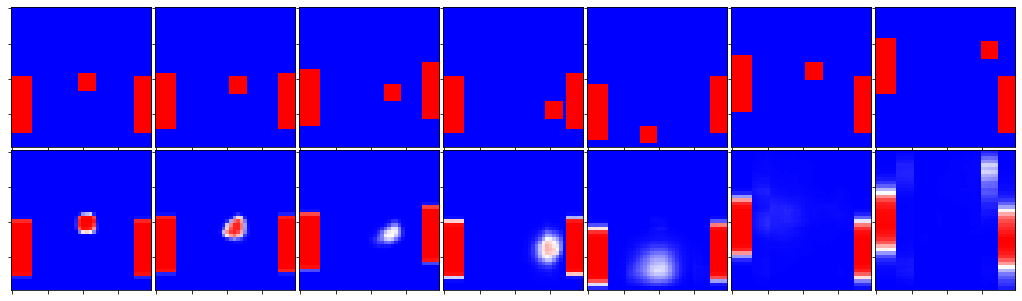

Epoch 58/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0726 - mean_squared_error: 0.0199 - acc: 0.9745 - val_loss: 0.0751 - val_mean_squared_error: 0.0206 - val_acc: 0.9737


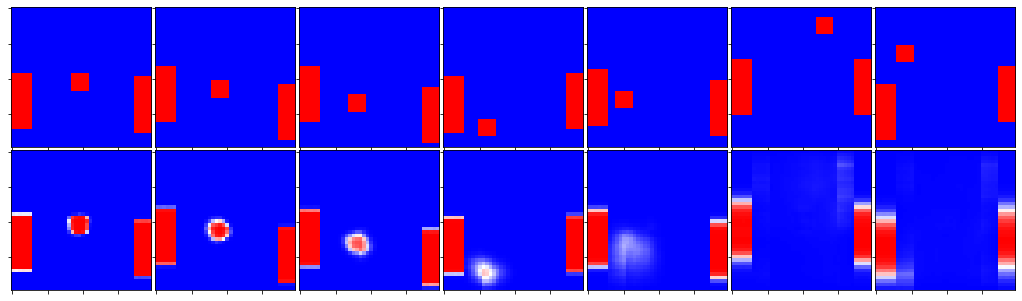

Epoch 59/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0734 - mean_squared_error: 0.0202 - acc: 0.9739 - val_loss: 0.0690 - val_mean_squared_error: 0.0189 - val_acc: 0.9758


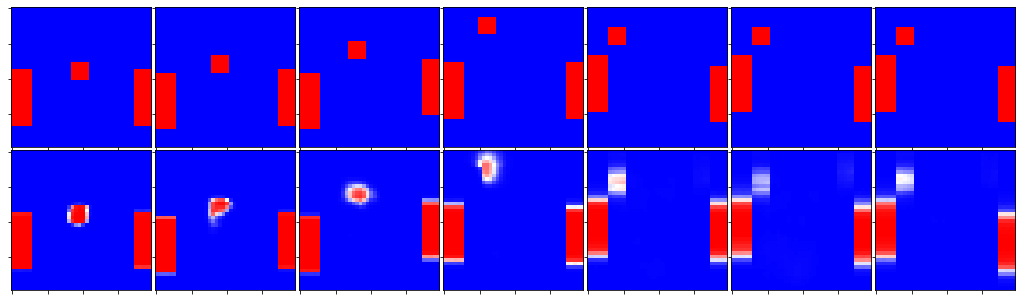

Epoch 60/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0713 - mean_squared_error: 0.0196 - acc: 0.9748 - val_loss: 0.0737 - val_mean_squared_error: 0.0203 - val_acc: 0.9740


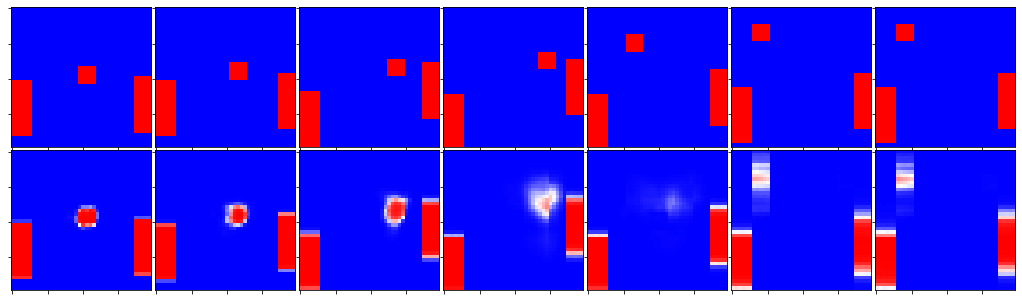

Epoch 61/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0710 - mean_squared_error: 0.0195 - acc: 0.9749 - val_loss: 0.0747 - val_mean_squared_error: 0.0206 - val_acc: 0.9730


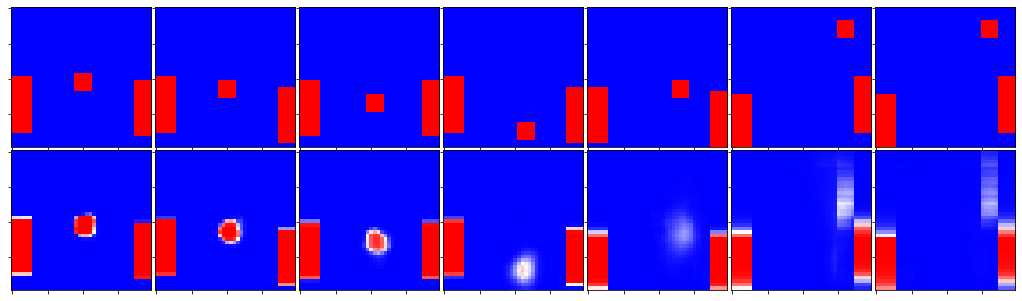

Epoch 62/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0717 - mean_squared_error: 0.0198 - acc: 0.9745 - val_loss: 0.0741 - val_mean_squared_error: 0.0202 - val_acc: 0.9740


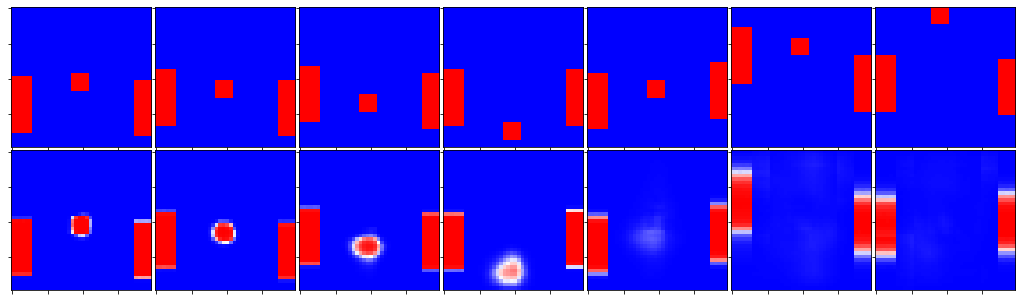

Epoch 63/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0701 - mean_squared_error: 0.0193 - acc: 0.9752 - val_loss: 0.0682 - val_mean_squared_error: 0.0189 - val_acc: 0.9755


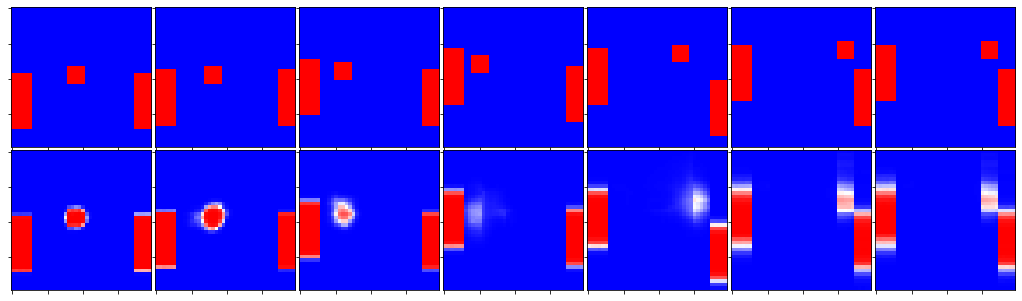

Epoch 64/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0697 - mean_squared_error: 0.0193 - acc: 0.9752 - val_loss: 0.0710 - val_mean_squared_error: 0.0194 - val_acc: 0.9750


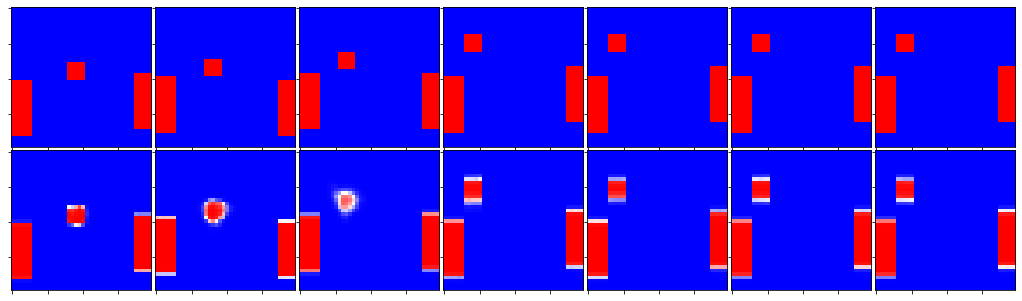

Epoch 65/2500
100/100 [==============================] - 82s 816ms/step - loss: 0.0694 - mean_squared_error: 0.0192 - acc: 0.9753 - val_loss: 0.0707 - val_mean_squared_error: 0.0193 - val_acc: 0.9756


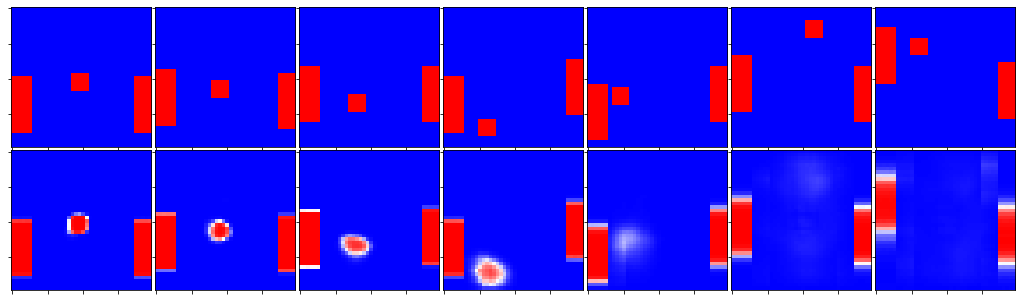

Epoch 66/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0705 - mean_squared_error: 0.0194 - acc: 0.9749 - val_loss: 0.0729 - val_mean_squared_error: 0.0201 - val_acc: 0.9741


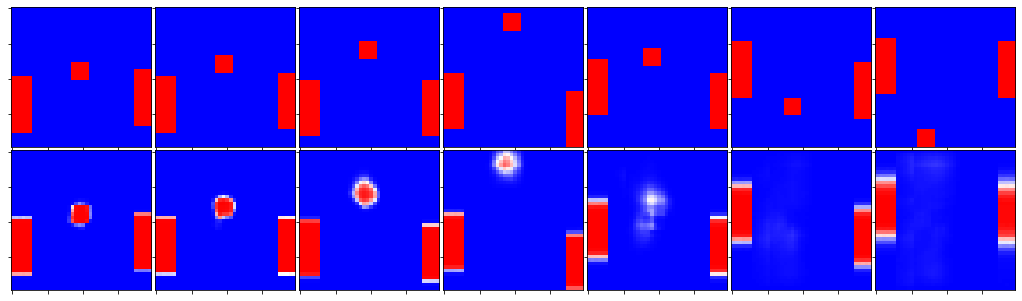

Epoch 67/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0693 - mean_squared_error: 0.0191 - acc: 0.9754 - val_loss: 0.0654 - val_mean_squared_error: 0.0182 - val_acc: 0.9762


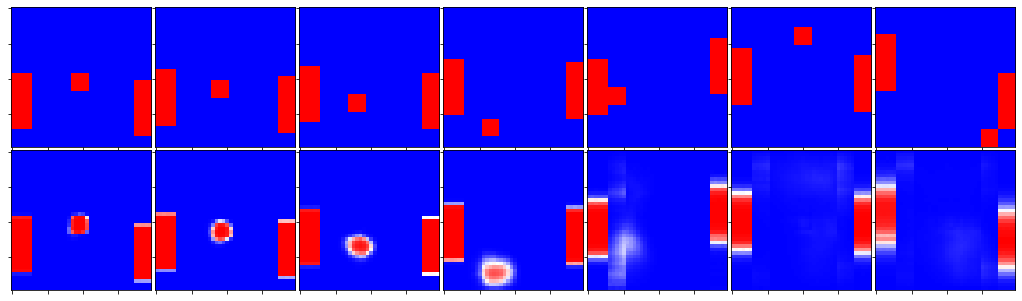

Epoch 68/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0680 - mean_squared_error: 0.0187 - acc: 0.9760 - val_loss: 0.0656 - val_mean_squared_error: 0.0180 - val_acc: 0.9768


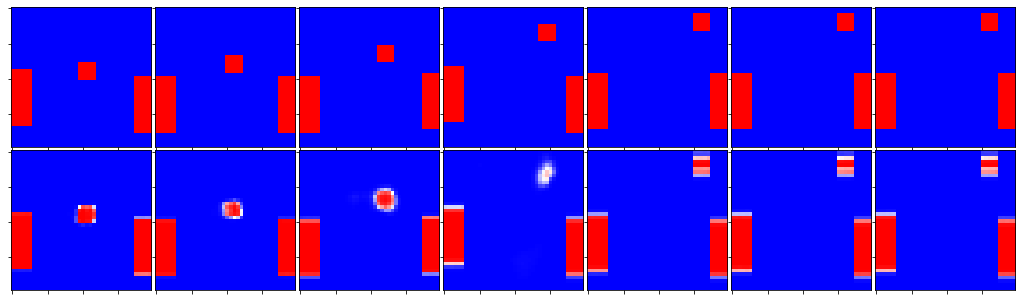

Epoch 69/2500
100/100 [==============================] - 81s 814ms/step - loss: 0.0682 - mean_squared_error: 0.0188 - acc: 0.9758 - val_loss: 0.0679 - val_mean_squared_error: 0.0187 - val_acc: 0.9759


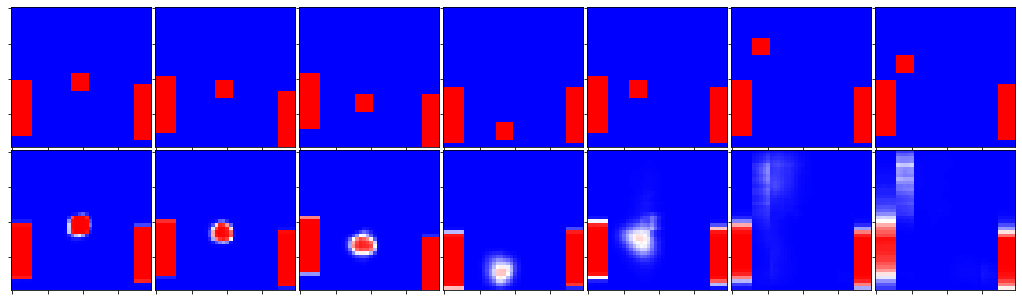

Epoch 70/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0695 - mean_squared_error: 0.0192 - acc: 0.9752 - val_loss: 0.0602 - val_mean_squared_error: 0.0166 - val_acc: 0.9783


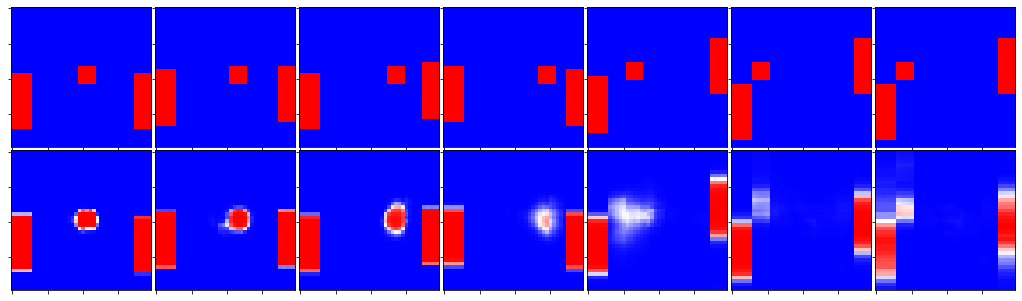

Epoch 71/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0677 - mean_squared_error: 0.0188 - acc: 0.9758 - val_loss: 0.0682 - val_mean_squared_error: 0.0187 - val_acc: 0.9759


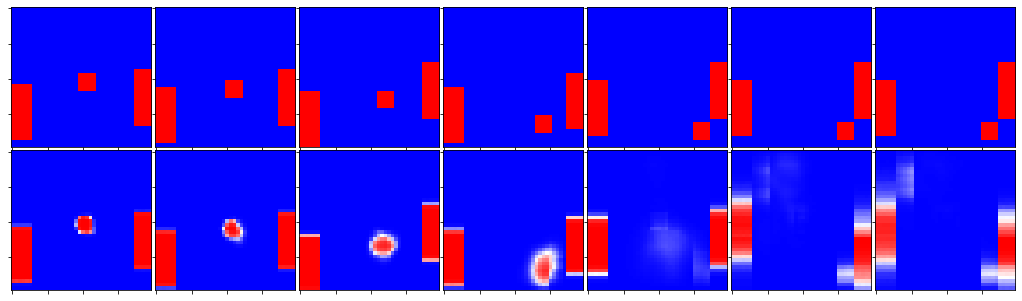

Epoch 72/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0684 - mean_squared_error: 0.0190 - acc: 0.9754 - val_loss: 0.0681 - val_mean_squared_error: 0.0189 - val_acc: 0.9759


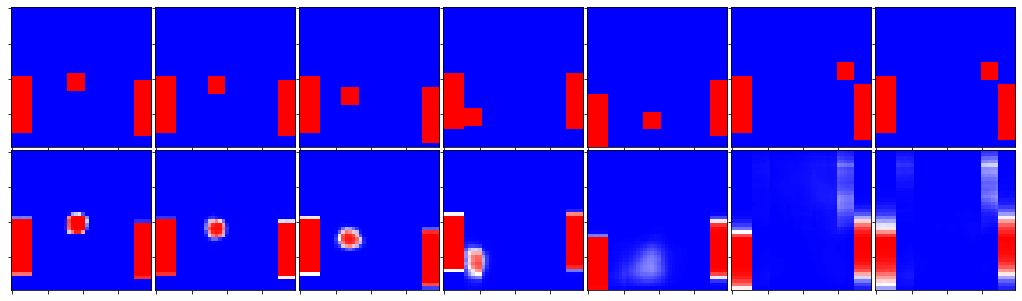

Epoch 73/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0671 - mean_squared_error: 0.0186 - acc: 0.9759 - val_loss: 0.0667 - val_mean_squared_error: 0.0189 - val_acc: 0.9754


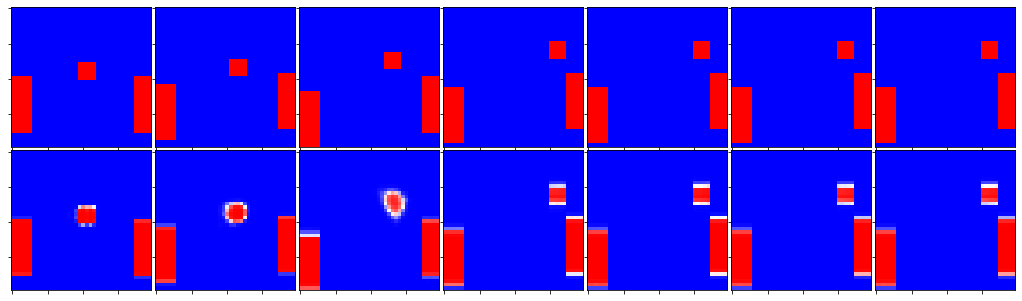

Epoch 74/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0670 - mean_squared_error: 0.0185 - acc: 0.9762 - val_loss: 0.0640 - val_mean_squared_error: 0.0179 - val_acc: 0.9764


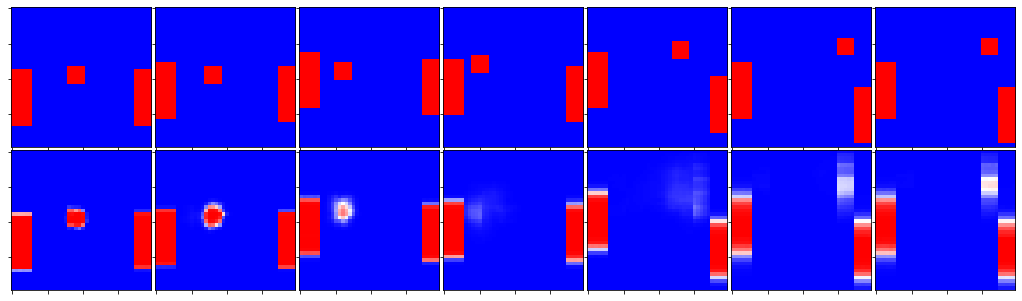

Epoch 75/2500
100/100 [==============================] - 81s 813ms/step - loss: 0.0668 - mean_squared_error: 0.0185 - acc: 0.9761 - val_loss: 0.0633 - val_mean_squared_error: 0.0174 - val_acc: 0.9779


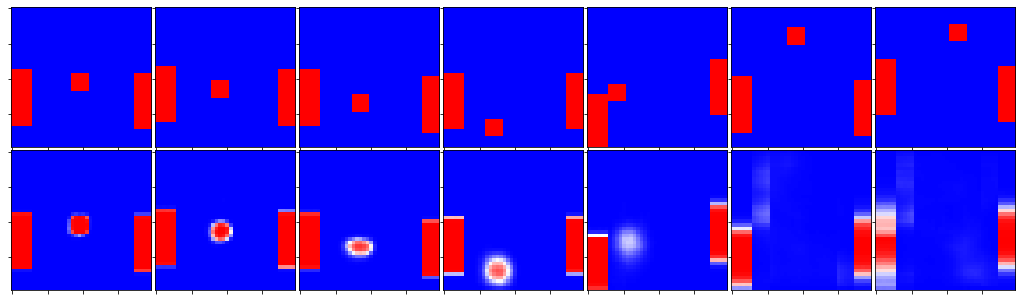

Epoch 76/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0669 - mean_squared_error: 0.0186 - acc: 0.9759 - val_loss: 0.0692 - val_mean_squared_error: 0.0191 - val_acc: 0.9752


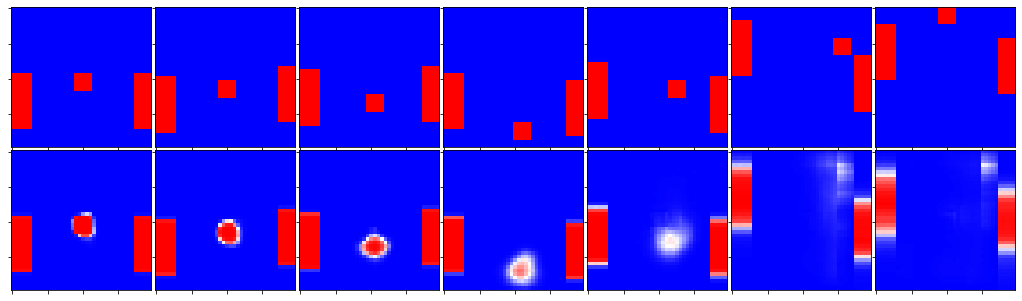

Epoch 77/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0665 - mean_squared_error: 0.0184 - acc: 0.9763 - val_loss: 0.0642 - val_mean_squared_error: 0.0183 - val_acc: 0.9761


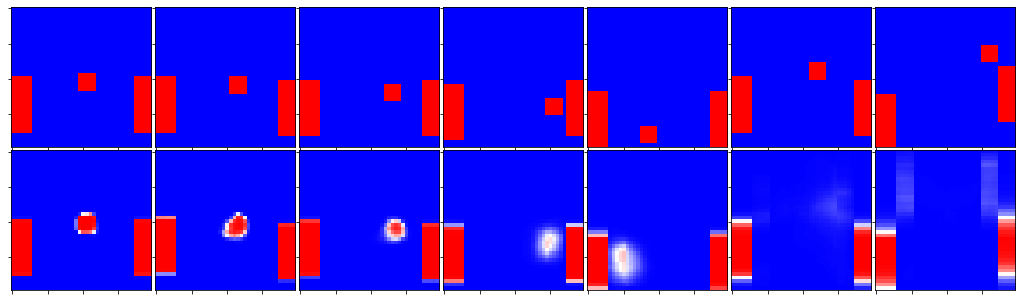

Epoch 78/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0650 - mean_squared_error: 0.0180 - acc: 0.9768 - val_loss: 0.0629 - val_mean_squared_error: 0.0173 - val_acc: 0.9778


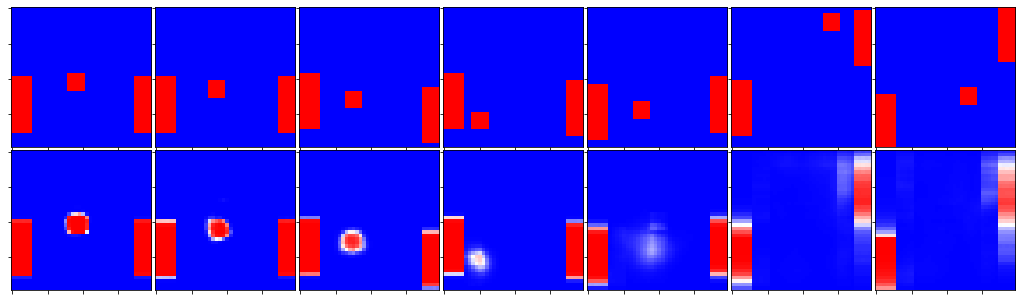

Epoch 79/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0658 - mean_squared_error: 0.0182 - acc: 0.9766 - val_loss: 0.0735 - val_mean_squared_error: 0.0190 - val_acc: 0.9762


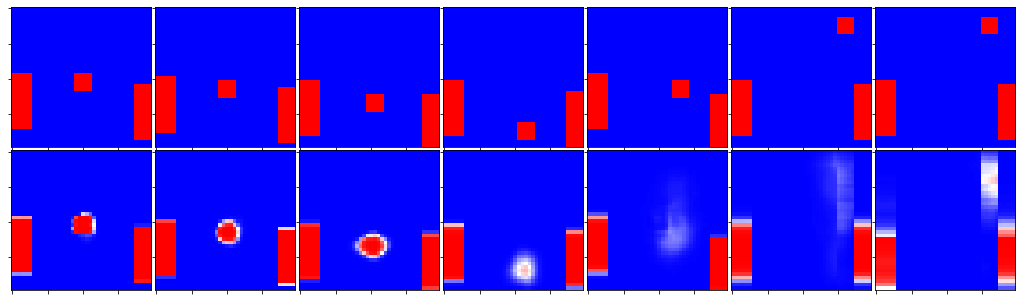

Epoch 80/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0635 - mean_squared_error: 0.0177 - acc: 0.9770 - val_loss: 0.0704 - val_mean_squared_error: 0.0192 - val_acc: 0.9754


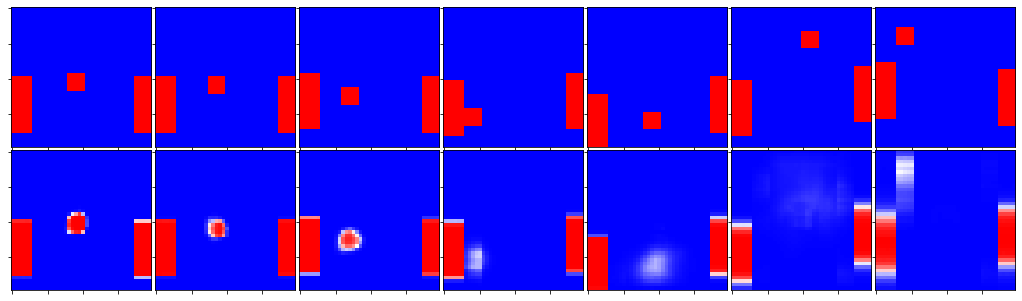

Epoch 81/2500
100/100 [==============================] - 82s 818ms/step - loss: 0.0651 - mean_squared_error: 0.0181 - acc: 0.9766 - val_loss: 0.0626 - val_mean_squared_error: 0.0176 - val_acc: 0.9770


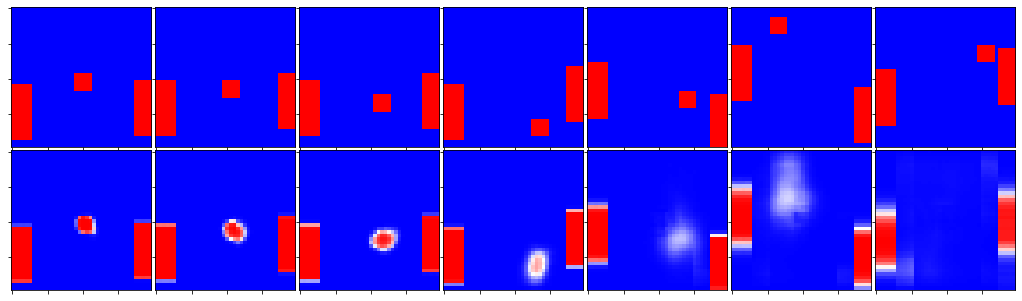

Epoch 82/2500
100/100 [==============================] - 81s 814ms/step - loss: 0.0648 - mean_squared_error: 0.0180 - acc: 0.9766 - val_loss: 0.0631 - val_mean_squared_error: 0.0176 - val_acc: 0.9773


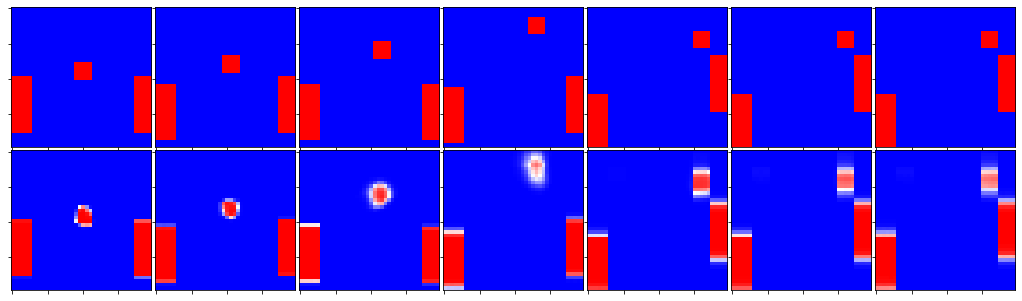

Epoch 83/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0631 - mean_squared_error: 0.0175 - acc: 0.9775 - val_loss: 0.0641 - val_mean_squared_error: 0.0172 - val_acc: 0.9781


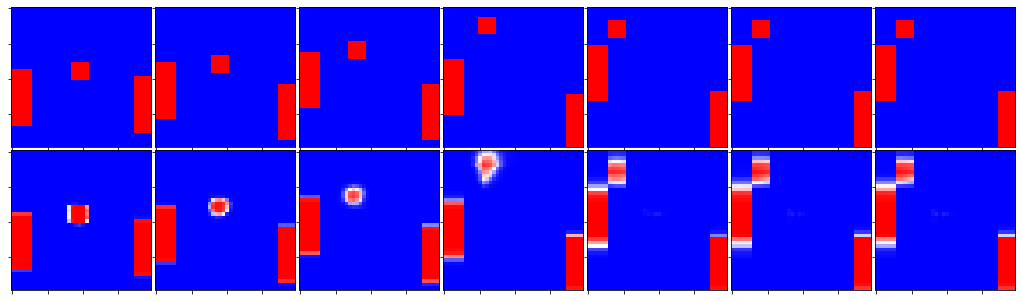

Epoch 84/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0641 - mean_squared_error: 0.0179 - acc: 0.9768 - val_loss: 0.0597 - val_mean_squared_error: 0.0165 - val_acc: 0.9789


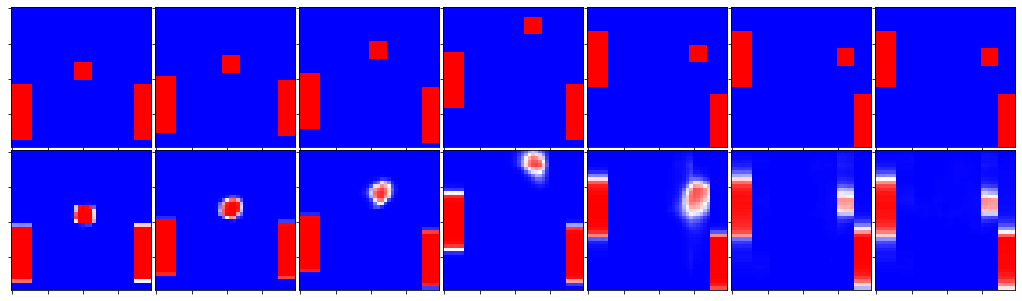

Epoch 85/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0630 - mean_squared_error: 0.0176 - acc: 0.9772 - val_loss: 0.0625 - val_mean_squared_error: 0.0175 - val_acc: 0.9771


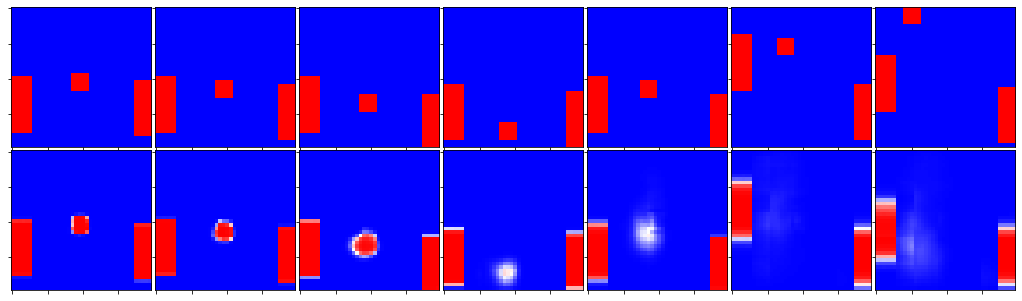

Epoch 86/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0651 - mean_squared_error: 0.0181 - acc: 0.9765 - val_loss: 0.0630 - val_mean_squared_error: 0.0171 - val_acc: 0.9785


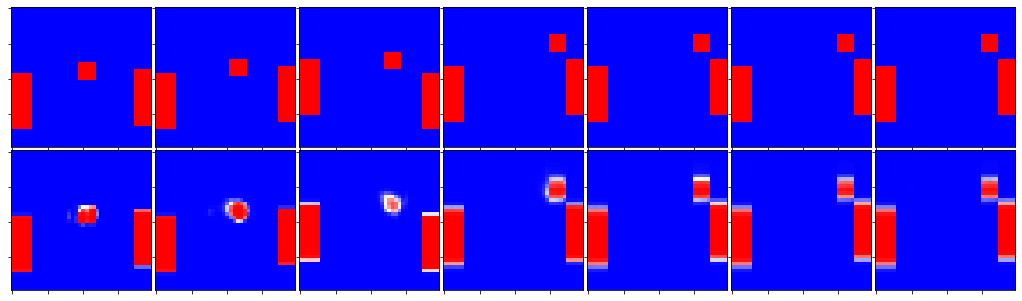

Epoch 87/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0626 - mean_squared_error: 0.0174 - acc: 0.9775 - val_loss: 0.0555 - val_mean_squared_error: 0.0160 - val_acc: 0.9785


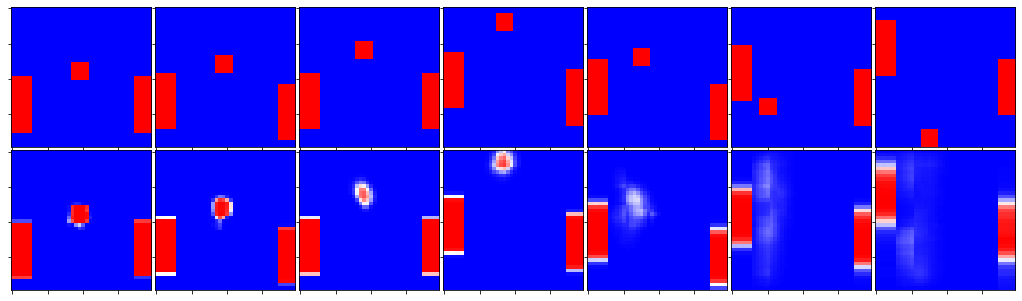

Epoch 88/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0629 - mean_squared_error: 0.0175 - acc: 0.9772 - val_loss: 0.0598 - val_mean_squared_error: 0.0167 - val_acc: 0.9785


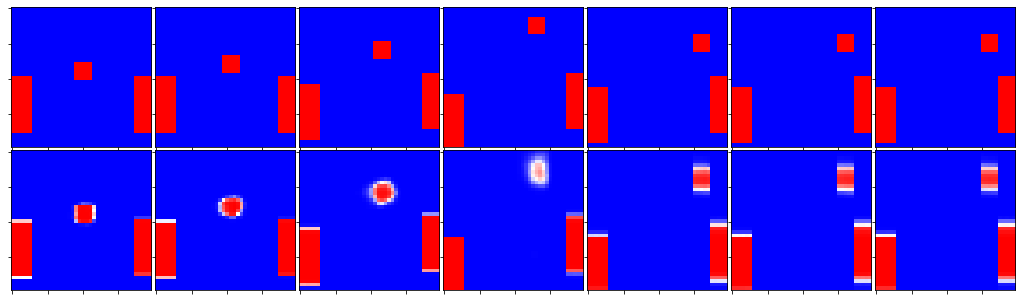

Epoch 89/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0641 - mean_squared_error: 0.0179 - acc: 0.9767 - val_loss: 0.0721 - val_mean_squared_error: 0.0196 - val_acc: 0.9746


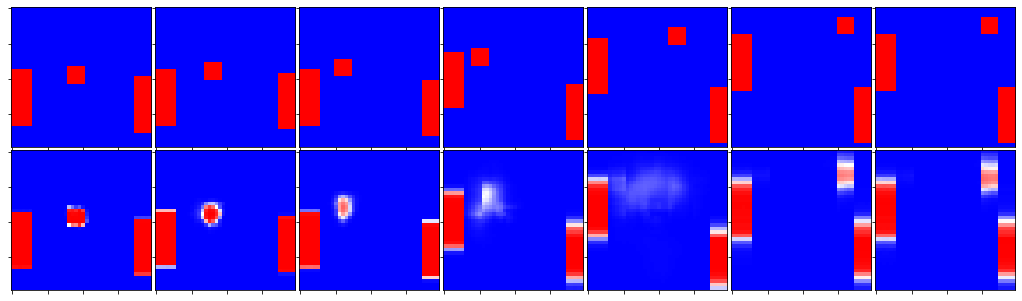

Epoch 90/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0651 - mean_squared_error: 0.0180 - acc: 0.9767 - val_loss: 0.0676 - val_mean_squared_error: 0.0187 - val_acc: 0.9758


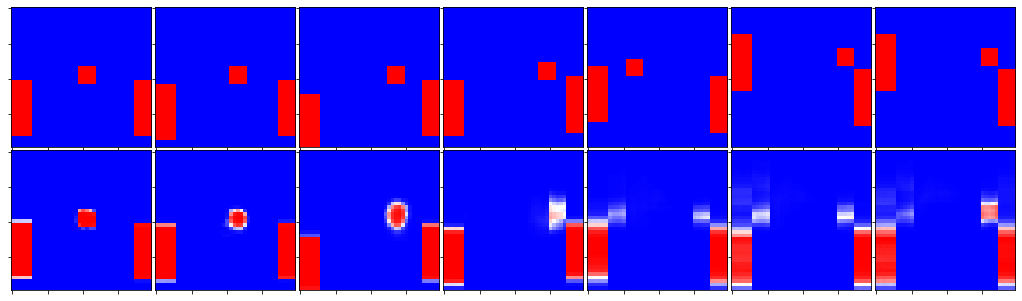

Epoch 91/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0617 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0608 - val_mean_squared_error: 0.0174 - val_acc: 0.9773


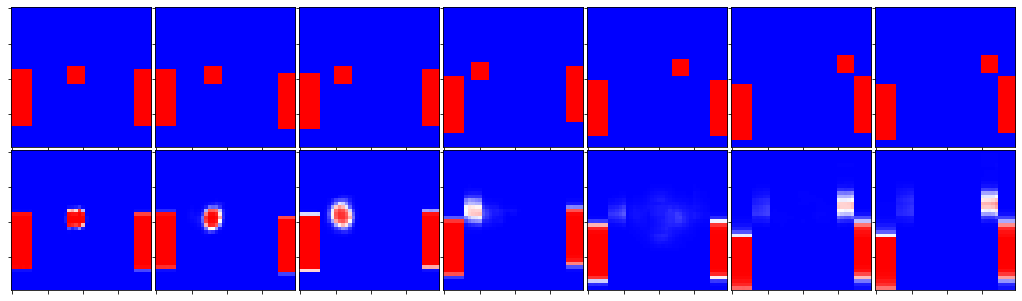

Epoch 92/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0614 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0595 - val_mean_squared_error: 0.0165 - val_acc: 0.9789


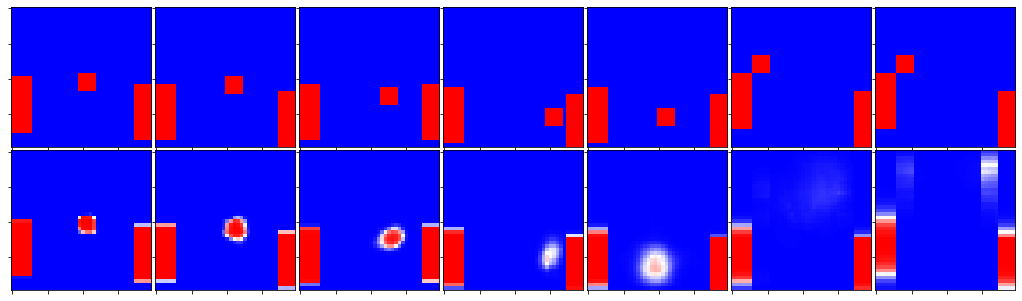

Epoch 93/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0603 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0604 - val_mean_squared_error: 0.0167 - val_acc: 0.9786


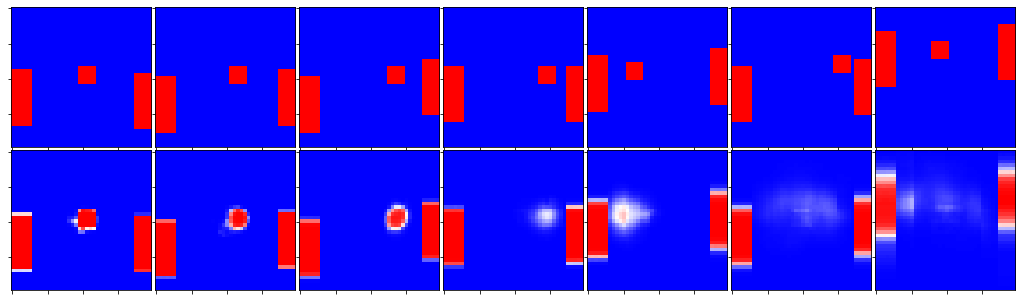

Epoch 94/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0614 - mean_squared_error: 0.0171 - acc: 0.9778 - val_loss: 0.0619 - val_mean_squared_error: 0.0171 - val_acc: 0.9782


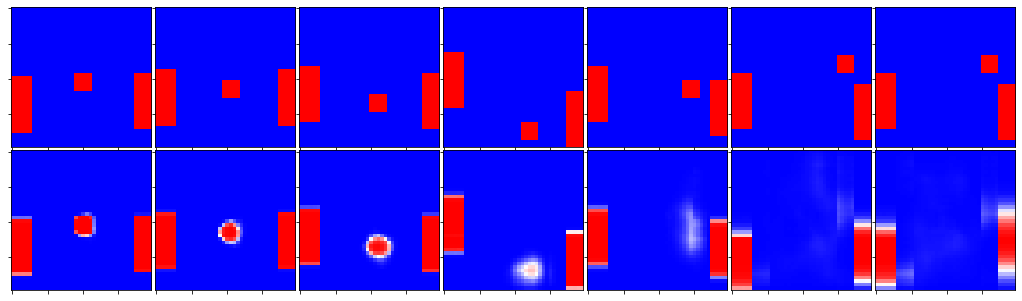

Epoch 95/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0612 - mean_squared_error: 0.0170 - acc: 0.9780 - val_loss: 0.0648 - val_mean_squared_error: 0.0184 - val_acc: 0.9753


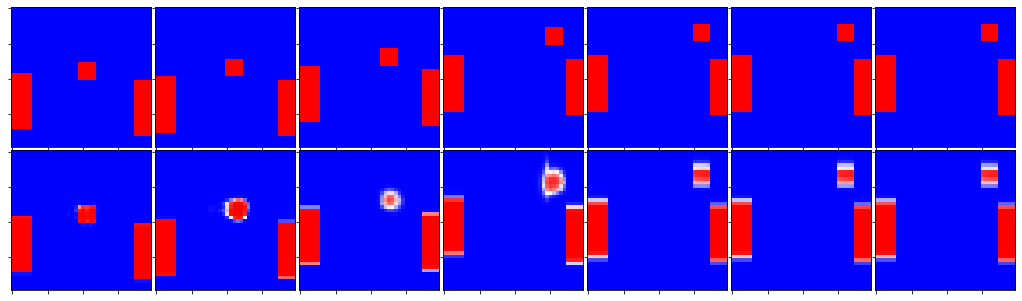

Epoch 96/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0610 - mean_squared_error: 0.0170 - acc: 0.9779 - val_loss: 0.0577 - val_mean_squared_error: 0.0159 - val_acc: 0.9796


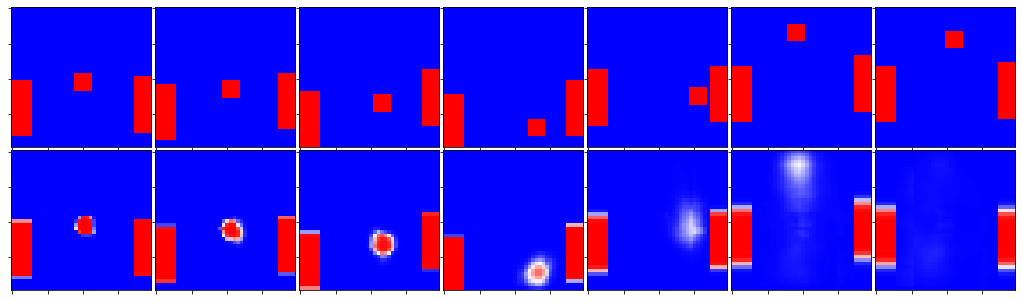

Epoch 97/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0605 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0608 - val_mean_squared_error: 0.0170 - val_acc: 0.9779


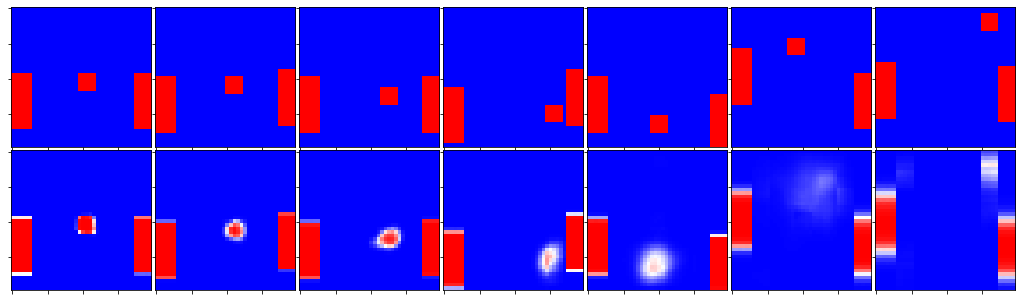

Epoch 98/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0595 - mean_squared_error: 0.0166 - acc: 0.9784 - val_loss: 0.0710 - val_mean_squared_error: 0.0191 - val_acc: 0.9751


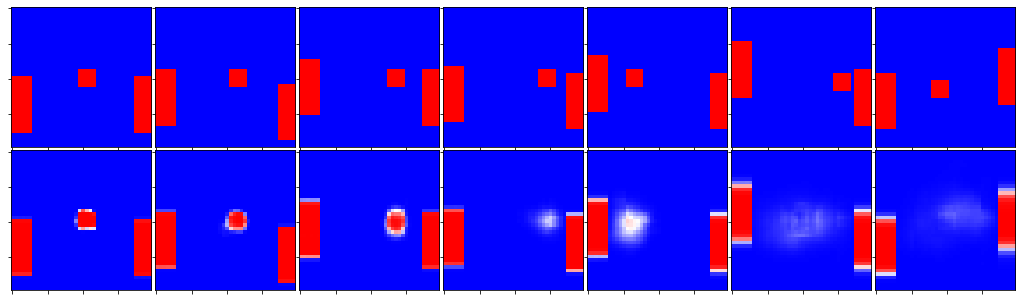

Epoch 99/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0622 - mean_squared_error: 0.0173 - acc: 0.9776 - val_loss: 0.0638 - val_mean_squared_error: 0.0181 - val_acc: 0.9764


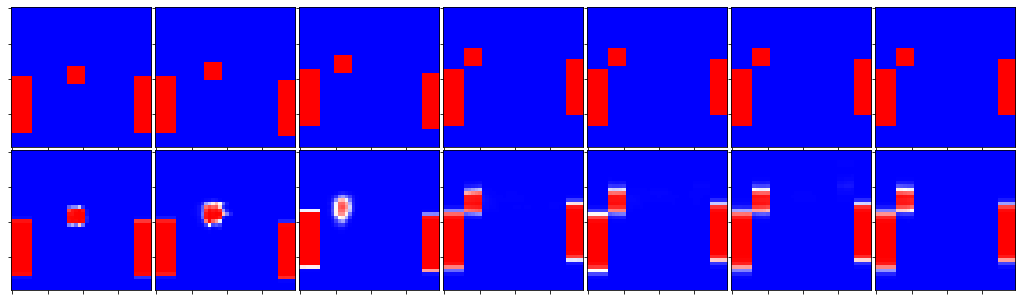

Epoch 100/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0629 - mean_squared_error: 0.0175 - acc: 0.9774 - val_loss: 0.0632 - val_mean_squared_error: 0.0176 - val_acc: 0.9774


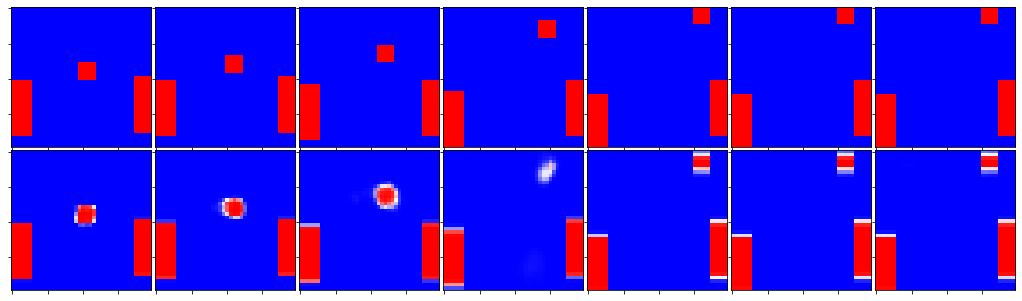

Epoch 101/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0600 - mean_squared_error: 0.0168 - acc: 0.9782 - val_loss: 0.0621 - val_mean_squared_error: 0.0174 - val_acc: 0.9774


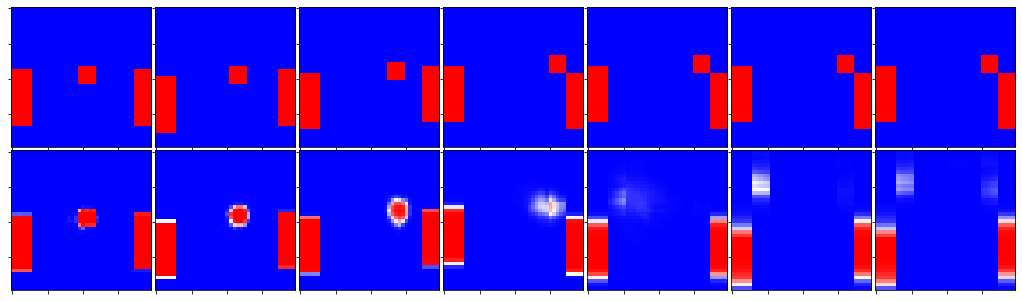

Epoch 102/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0599 - mean_squared_error: 0.0167 - acc: 0.9782 - val_loss: 0.0570 - val_mean_squared_error: 0.0160 - val_acc: 0.9790


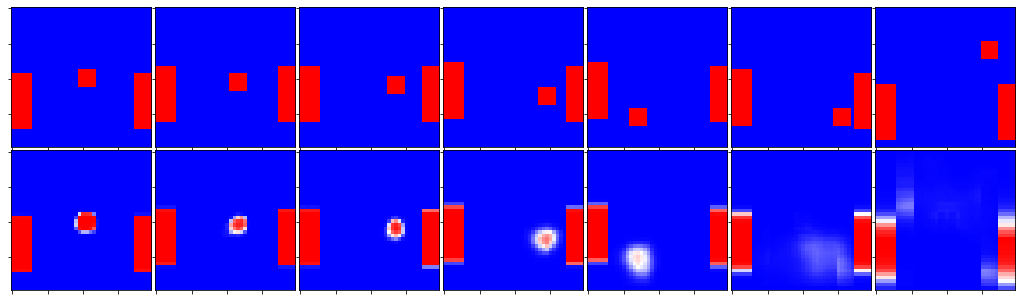

Epoch 103/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0592 - mean_squared_error: 0.0165 - acc: 0.9784 - val_loss: 0.0644 - val_mean_squared_error: 0.0176 - val_acc: 0.9769


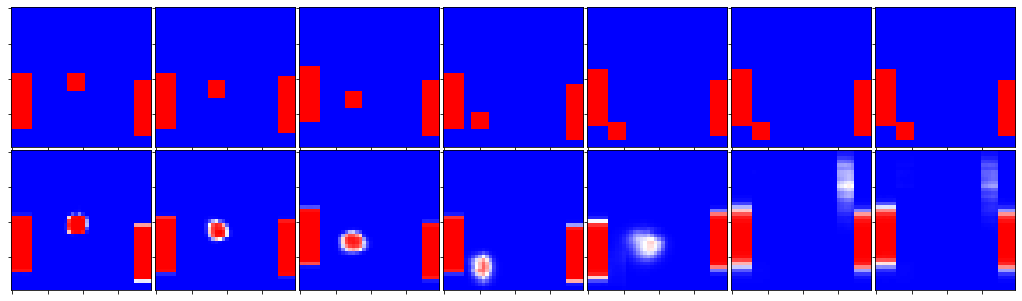

Epoch 104/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0613 - mean_squared_error: 0.0171 - acc: 0.9777 - val_loss: 0.0689 - val_mean_squared_error: 0.0192 - val_acc: 0.9748


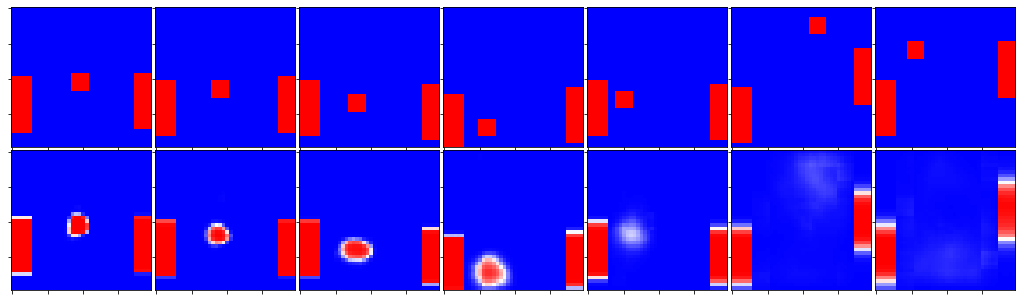

Epoch 105/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0660 - mean_squared_error: 0.0184 - acc: 0.9761 - val_loss: 0.0534 - val_mean_squared_error: 0.0149 - val_acc: 0.9805


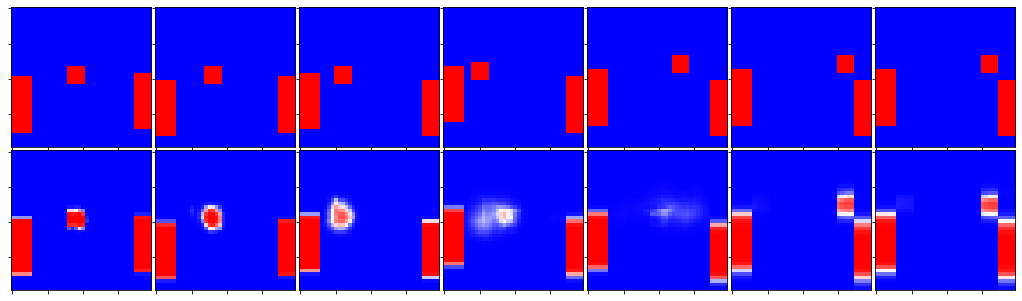

Epoch 106/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0623 - mean_squared_error: 0.0174 - acc: 0.9774 - val_loss: 0.0566 - val_mean_squared_error: 0.0160 - val_acc: 0.9792


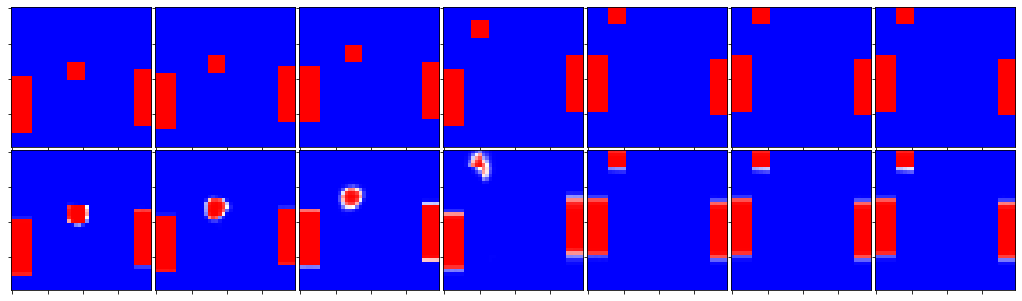

Epoch 107/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0605 - mean_squared_error: 0.0168 - acc: 0.9781 - val_loss: 0.0616 - val_mean_squared_error: 0.0170 - val_acc: 0.9780


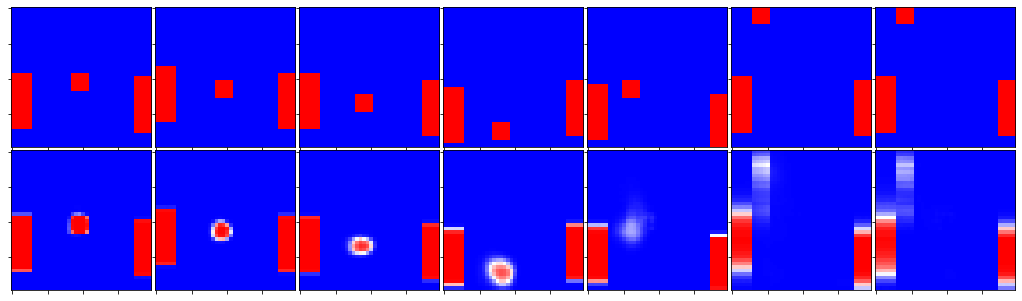

Epoch 108/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0598 - mean_squared_error: 0.0167 - acc: 0.9782 - val_loss: 0.0542 - val_mean_squared_error: 0.0152 - val_acc: 0.9805


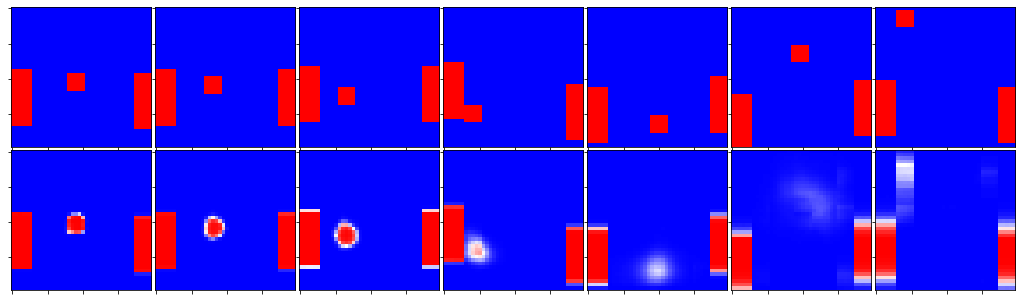

Epoch 109/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0579 - mean_squared_error: 0.0161 - acc: 0.9790 - val_loss: 0.0552 - val_mean_squared_error: 0.0154 - val_acc: 0.9797


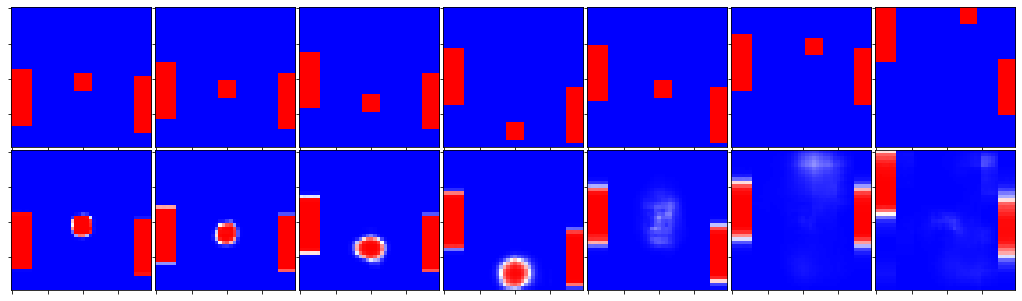

Epoch 110/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0584 - mean_squared_error: 0.0163 - acc: 0.9788 - val_loss: 0.0563 - val_mean_squared_error: 0.0158 - val_acc: 0.9797


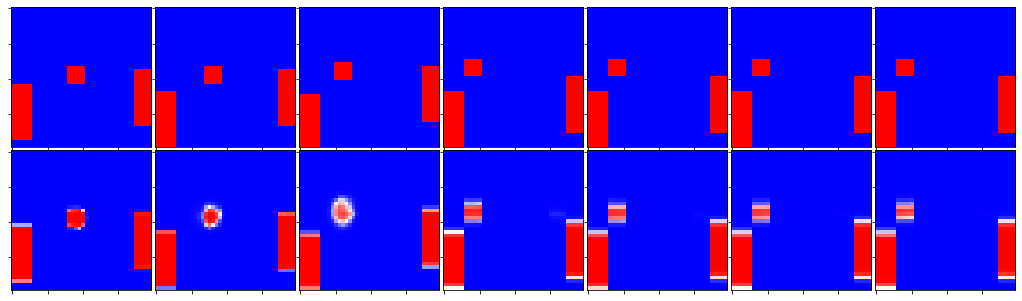

Epoch 111/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0569 - mean_squared_error: 0.0159 - acc: 0.9793 - val_loss: 0.0569 - val_mean_squared_error: 0.0159 - val_acc: 0.9795


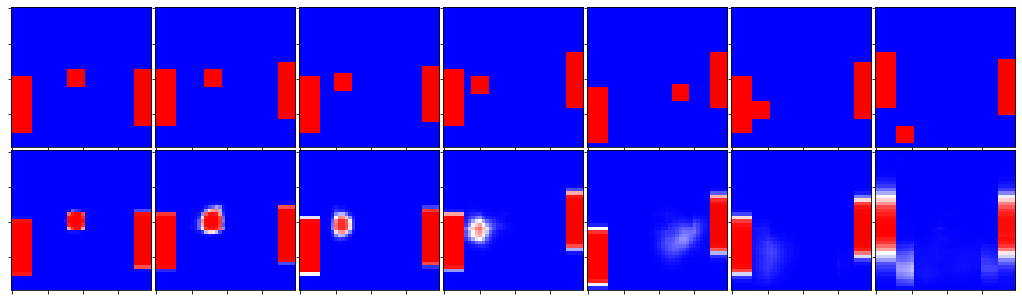

Epoch 112/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0581 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0643 - val_mean_squared_error: 0.0180 - val_acc: 0.9765


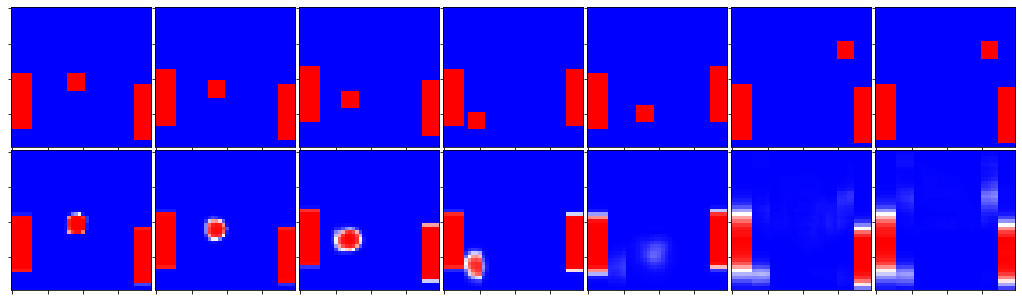

Epoch 113/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9793 - val_loss: 0.0570 - val_mean_squared_error: 0.0159 - val_acc: 0.9793


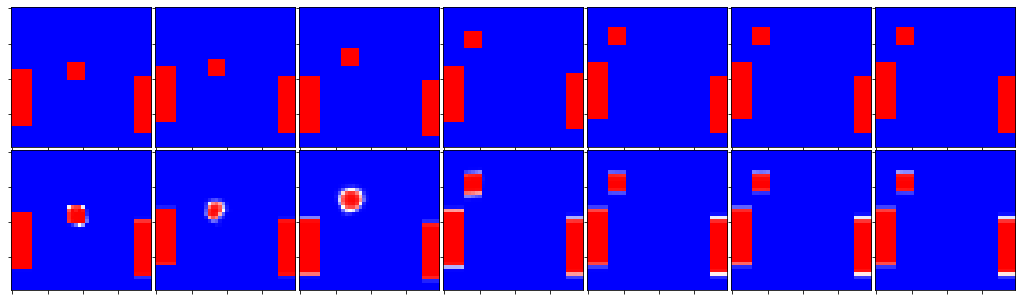

Epoch 114/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0602 - mean_squared_error: 0.0168 - acc: 0.9781 - val_loss: 0.0581 - val_mean_squared_error: 0.0164 - val_acc: 0.9785


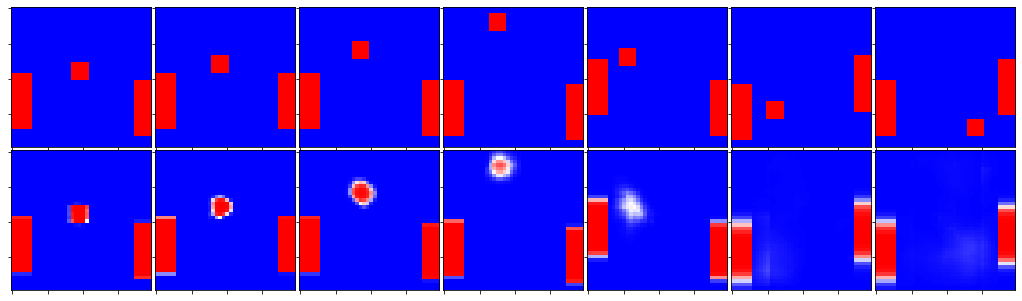

Epoch 115/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0585 - mean_squared_error: 0.0163 - acc: 0.9788 - val_loss: 0.0615 - val_mean_squared_error: 0.0173 - val_acc: 0.9774


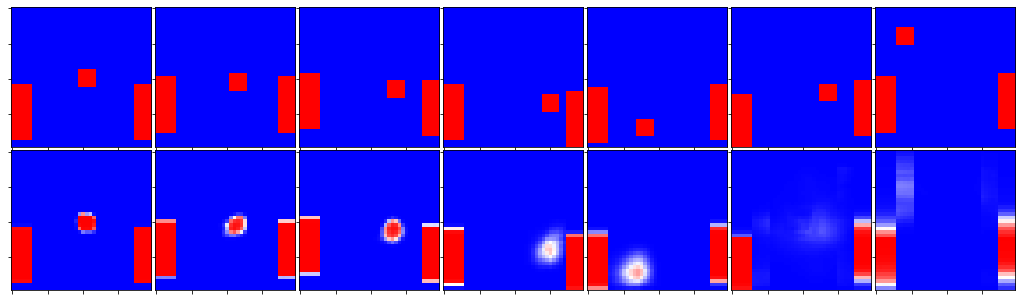

Epoch 116/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9793 - val_loss: 0.0624 - val_mean_squared_error: 0.0175 - val_acc: 0.9769


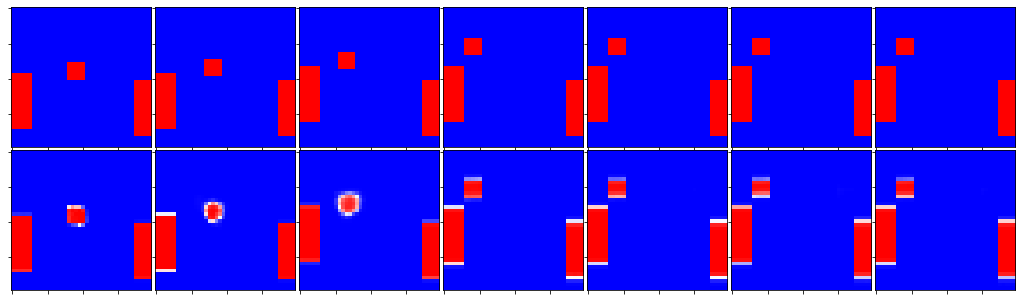

Epoch 117/2500
100/100 [==============================] - 82s 821ms/step - loss: 0.0587 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0618 - val_mean_squared_error: 0.0170 - val_acc: 0.9781


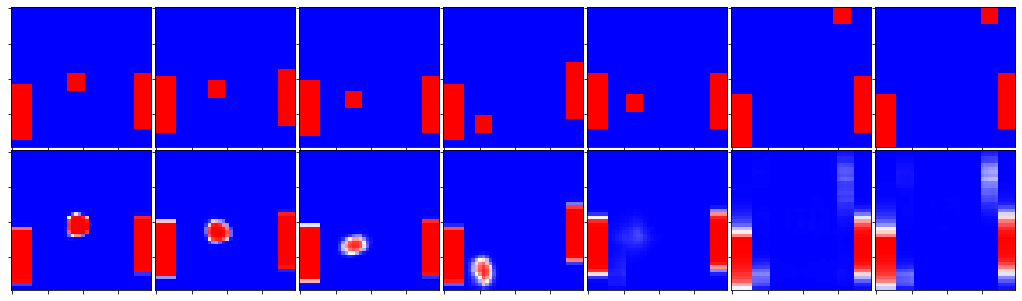

Epoch 118/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0586 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0563 - val_mean_squared_error: 0.0159 - val_acc: 0.9792


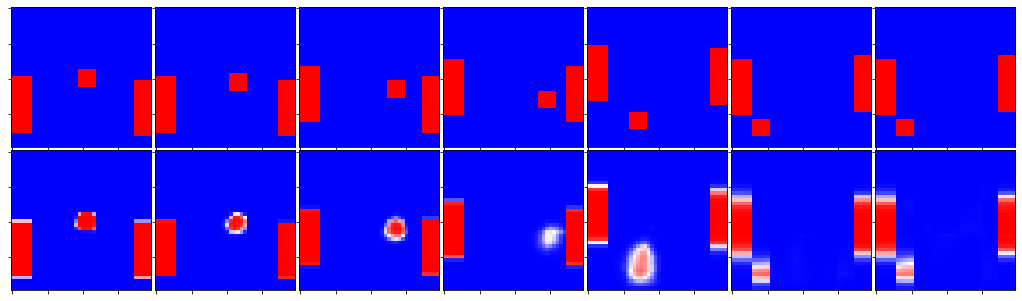

Epoch 119/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0558 - mean_squared_error: 0.0156 - acc: 0.9796 - val_loss: 0.0574 - val_mean_squared_error: 0.0161 - val_acc: 0.9790


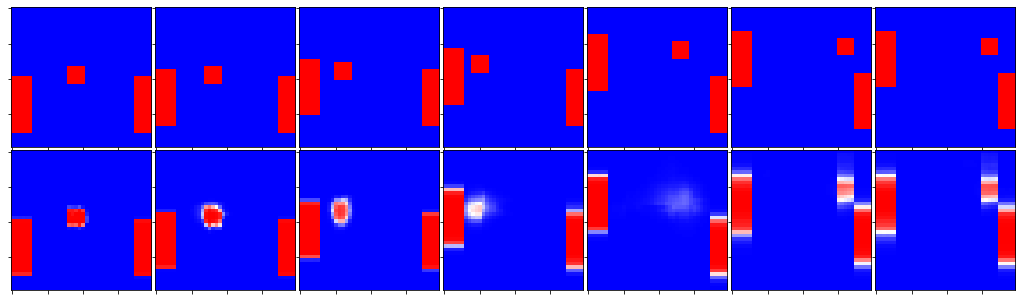

Epoch 120/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0567 - mean_squared_error: 0.0158 - acc: 0.9794 - val_loss: 0.0510 - val_mean_squared_error: 0.0140 - val_acc: 0.9816


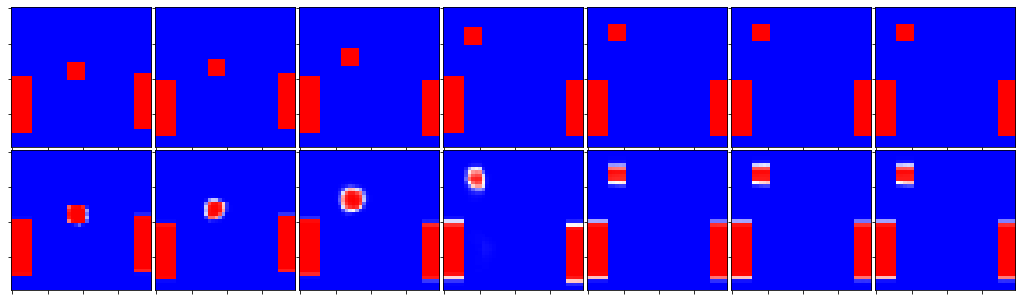

Epoch 121/2500
100/100 [==============================] - 82s 819ms/step - loss: 0.0574 - mean_squared_error: 0.0161 - acc: 0.9790 - val_loss: 0.0539 - val_mean_squared_error: 0.0151 - val_acc: 0.9801


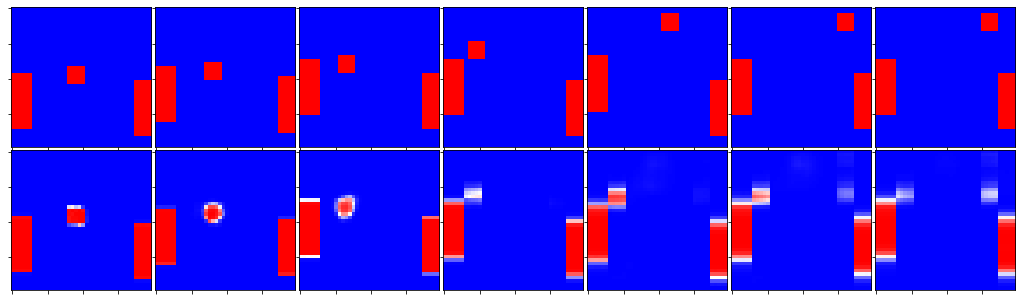

Epoch 122/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0573 - mean_squared_error: 0.0160 - acc: 0.9792 - val_loss: 0.0612 - val_mean_squared_error: 0.0169 - val_acc: 0.9780


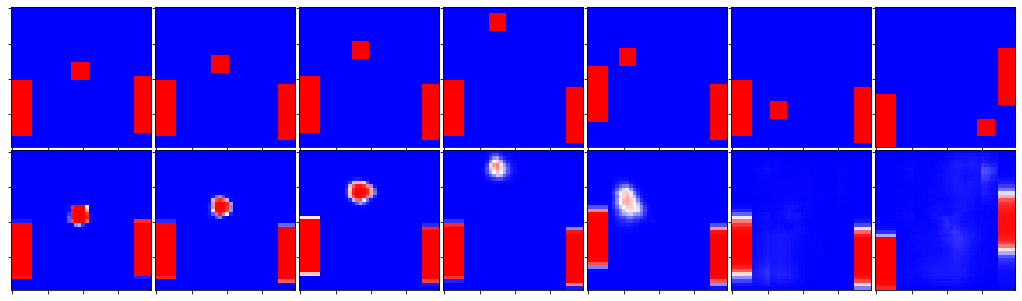

Epoch 123/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0586 - mean_squared_error: 0.0164 - acc: 0.9786 - val_loss: 0.0523 - val_mean_squared_error: 0.0149 - val_acc: 0.9803


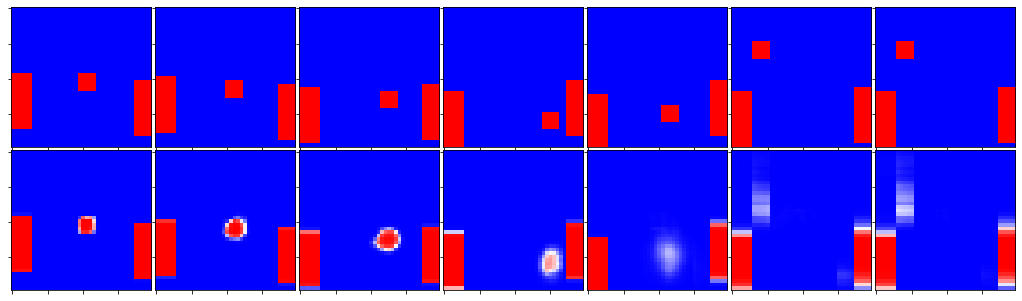

Epoch 124/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0586 - mean_squared_error: 0.0163 - acc: 0.9787 - val_loss: 0.0551 - val_mean_squared_error: 0.0152 - val_acc: 0.9806


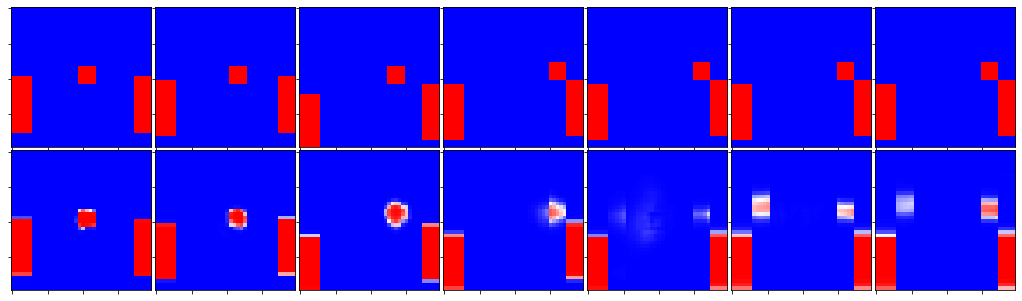

Epoch 125/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0556 - mean_squared_error: 0.0156 - acc: 0.9796 - val_loss: 0.0580 - val_mean_squared_error: 0.0164 - val_acc: 0.9782


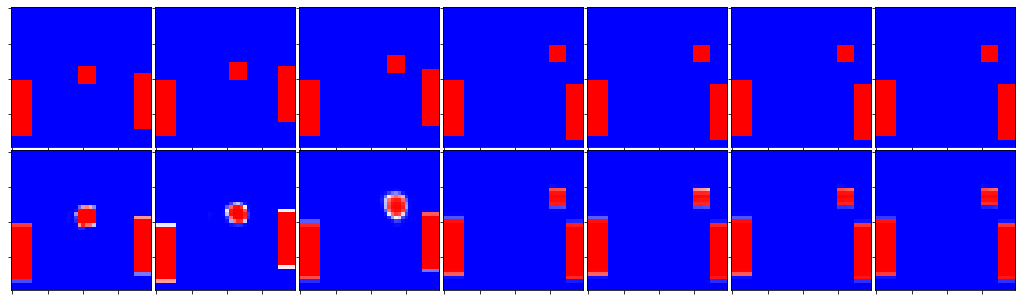

Epoch 126/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0558 - mean_squared_error: 0.0156 - acc: 0.9795 - val_loss: 0.0535 - val_mean_squared_error: 0.0151 - val_acc: 0.9806


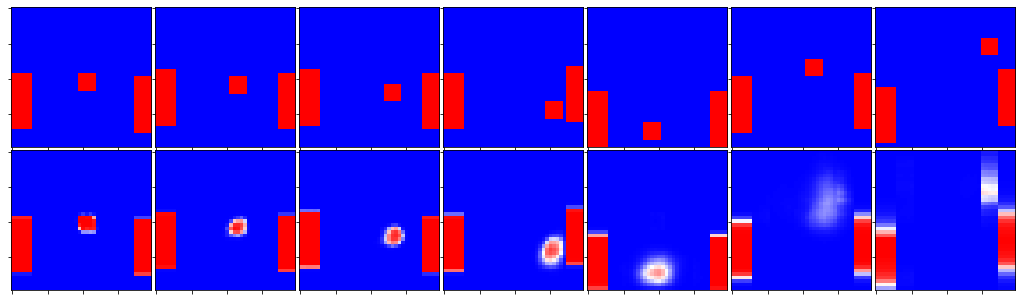

Epoch 127/2500
100/100 [==============================] - 82s 823ms/step - loss: 0.0554 - mean_squared_error: 0.0155 - acc: 0.9796 - val_loss: 0.0582 - val_mean_squared_error: 0.0161 - val_acc: 0.9791


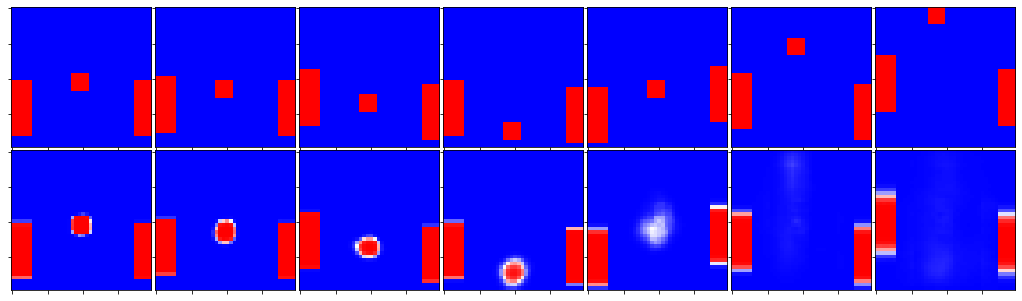

Epoch 128/2500
100/100 [==============================] - 82s 817ms/step - loss: 0.0563 - mean_squared_error: 0.0158 - acc: 0.9792 - val_loss: 0.0555 - val_mean_squared_error: 0.0157 - val_acc: 0.9795


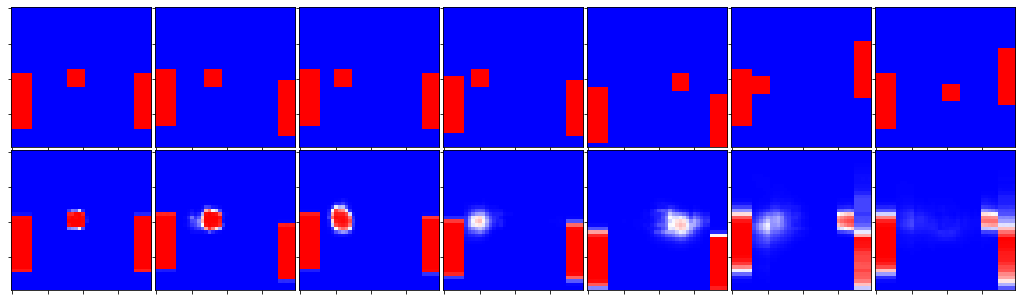

Epoch 129/2500
100/100 [==============================] - 82s 824ms/step - loss: 0.0529 - mean_squared_error: 0.0149 - acc: 0.9805 - val_loss: 0.0671 - val_mean_squared_error: 0.0160 - val_acc: 0.9790


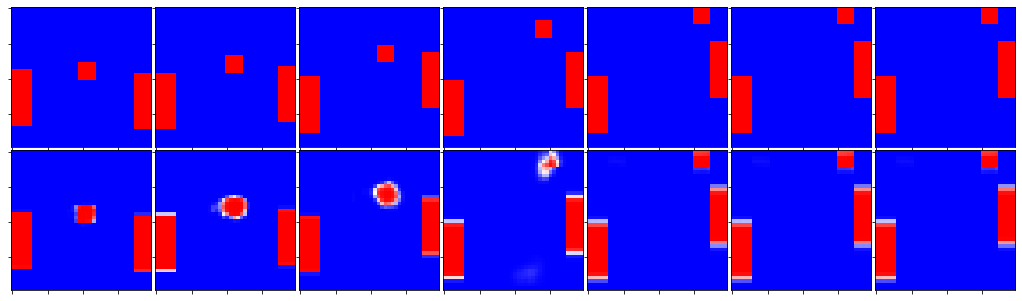

Epoch 130/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0546 - mean_squared_error: 0.0153 - acc: 0.9798 - val_loss: 0.0518 - val_mean_squared_error: 0.0146 - val_acc: 0.9805


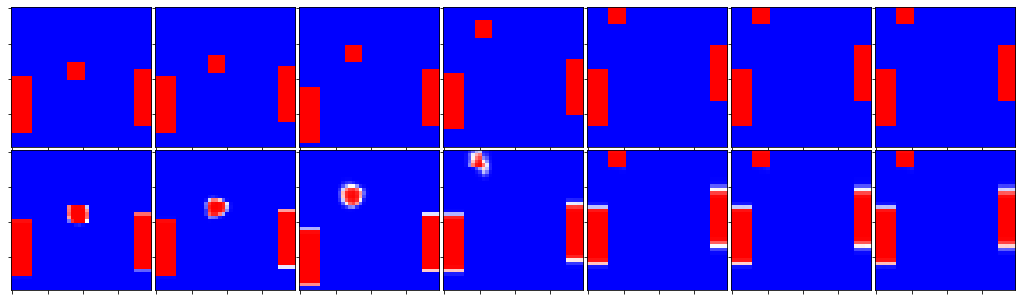

Epoch 131/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0551 - mean_squared_error: 0.0154 - acc: 0.9799 - val_loss: 0.0539 - val_mean_squared_error: 0.0151 - val_acc: 0.9801


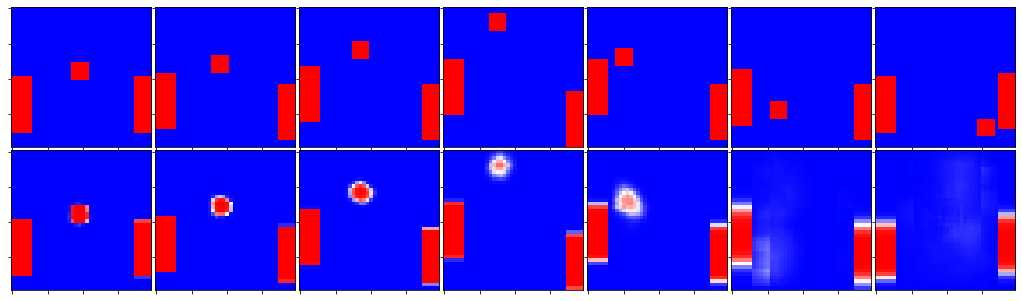

Epoch 132/2500
100/100 [==============================] - 83s 825ms/step - loss: 0.0542 - mean_squared_error: 0.0152 - acc: 0.9800 - val_loss: 0.0558 - val_mean_squared_error: 0.0154 - val_acc: 0.9799


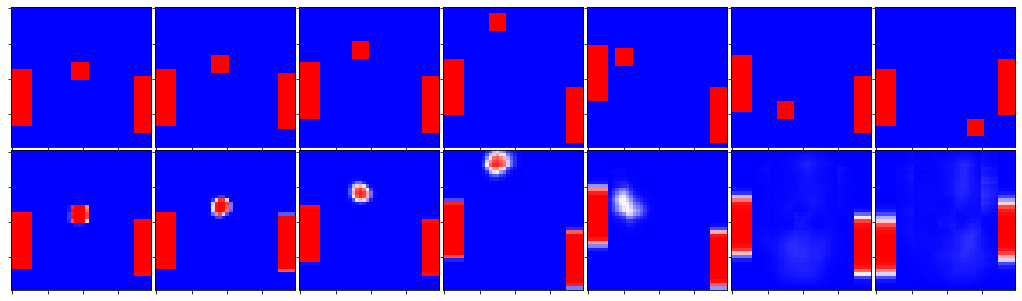

Epoch 133/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0543 - mean_squared_error: 0.0152 - acc: 0.9801 - val_loss: 0.0522 - val_mean_squared_error: 0.0149 - val_acc: 0.9801


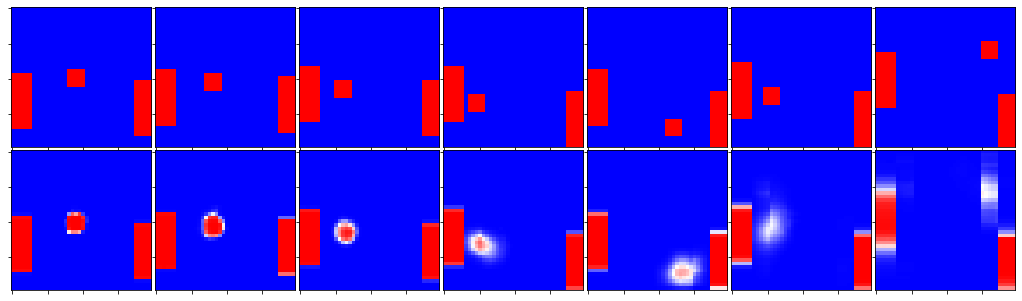

Epoch 134/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0548 - mean_squared_error: 0.0154 - acc: 0.9798 - val_loss: 0.0567 - val_mean_squared_error: 0.0160 - val_acc: 0.9792


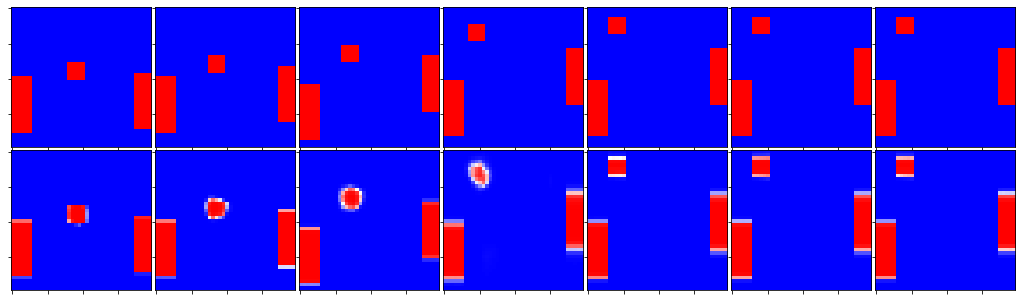

Epoch 135/2500
100/100 [==============================] - 82s 825ms/step - loss: 0.0538 - mean_squared_error: 0.0151 - acc: 0.9801 - val_loss: 0.0526 - val_mean_squared_error: 0.0148 - val_acc: 0.9808


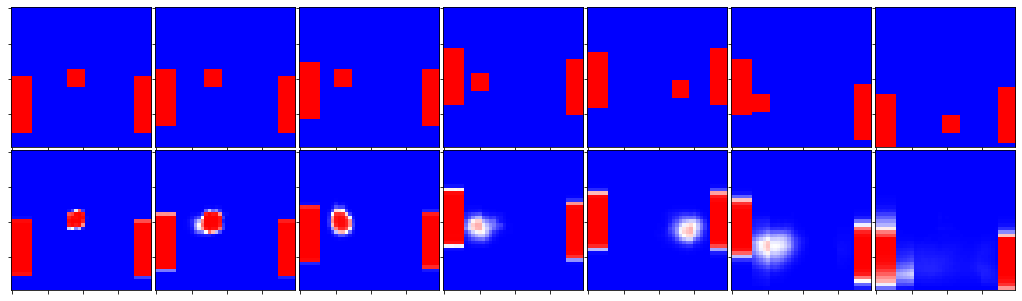

Epoch 136/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0539 - mean_squared_error: 0.0151 - acc: 0.9801 - val_loss: 0.0547 - val_mean_squared_error: 0.0154 - val_acc: 0.9796


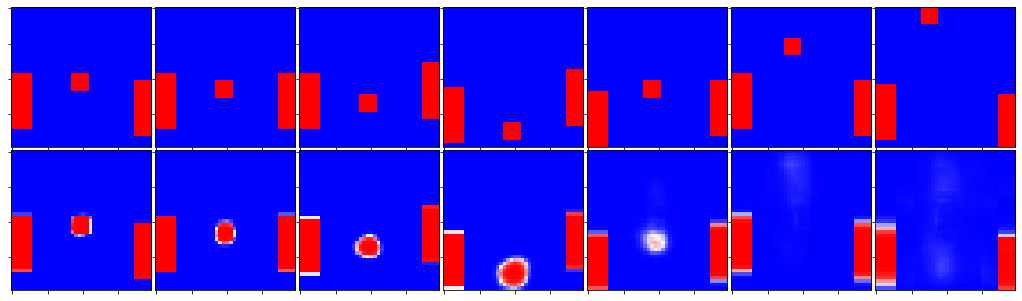

Epoch 137/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0548 - mean_squared_error: 0.0154 - acc: 0.9798 - val_loss: 0.0476 - val_mean_squared_error: 0.0137 - val_acc: 0.9820


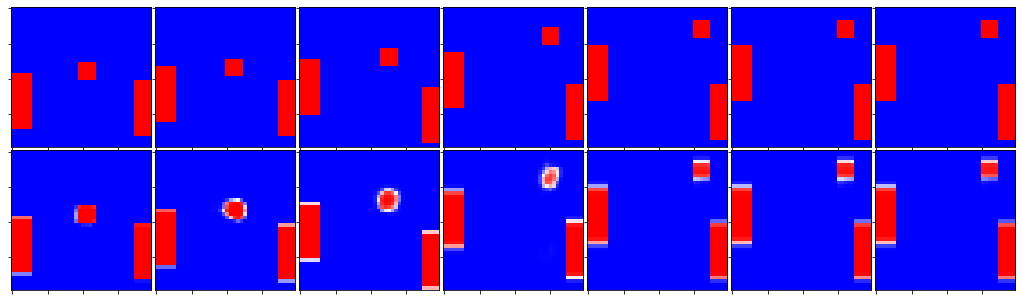

Epoch 138/2500
100/100 [==============================] - 83s 827ms/step - loss: 0.0528 - mean_squared_error: 0.0148 - acc: 0.9805 - val_loss: 0.0641 - val_mean_squared_error: 0.0177 - val_acc: 0.9771


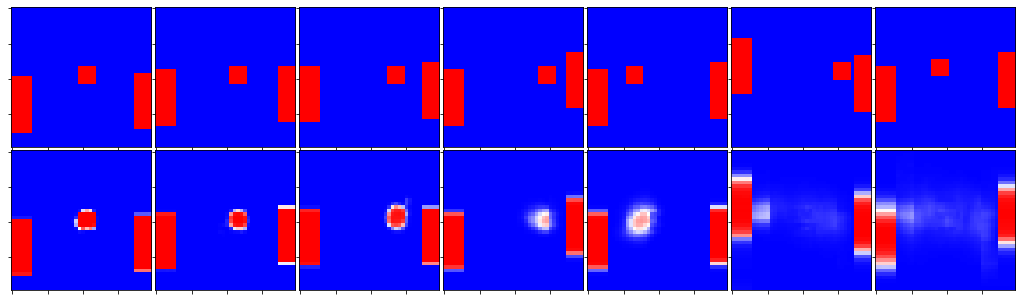

Epoch 139/2500
100/100 [==============================] - 83s 828ms/step - loss: 0.0532 - mean_squared_error: 0.0149 - acc: 0.9804 - val_loss: 0.0498 - val_mean_squared_error: 0.0137 - val_acc: 0.9822


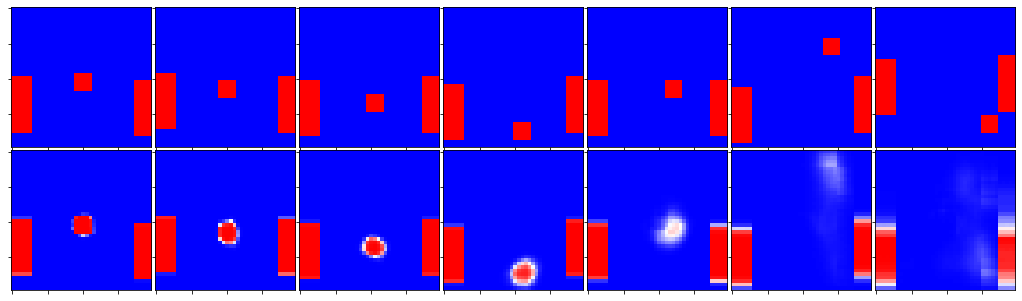

Epoch 140/2500
100/100 [==============================] - 82s 820ms/step - loss: 0.0535 - mean_squared_error: 0.0150 - acc: 0.9804 - val_loss: 0.0547 - val_mean_squared_error: 0.0154 - val_acc: 0.9801


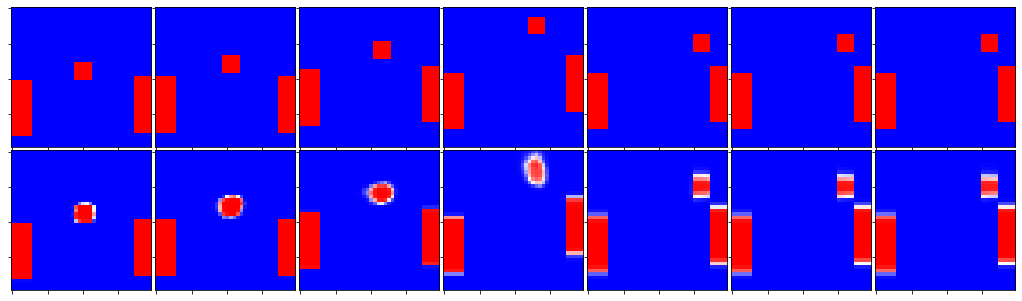

Epoch 141/2500
100/100 [==============================] - 82s 822ms/step - loss: 0.0526 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0528 - val_mean_squared_error: 0.0148 - val_acc: 0.9808


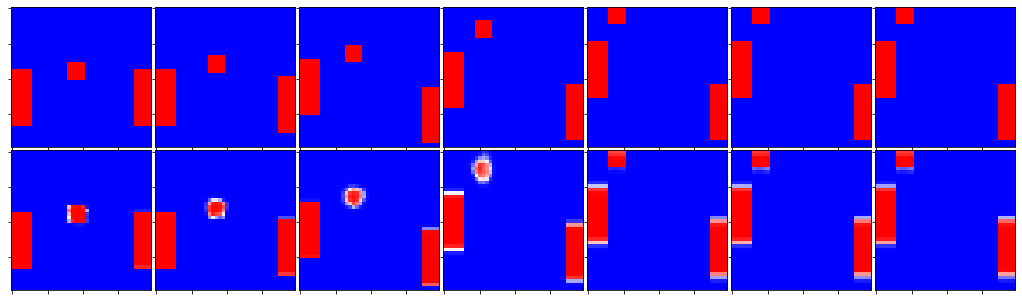

Epoch 142/2500
100/100 [==============================] - 84s 844ms/step - loss: 0.0531 - mean_squared_error: 0.0149 - acc: 0.9804 - val_loss: 0.0520 - val_mean_squared_error: 0.0146 - val_acc: 0.9807


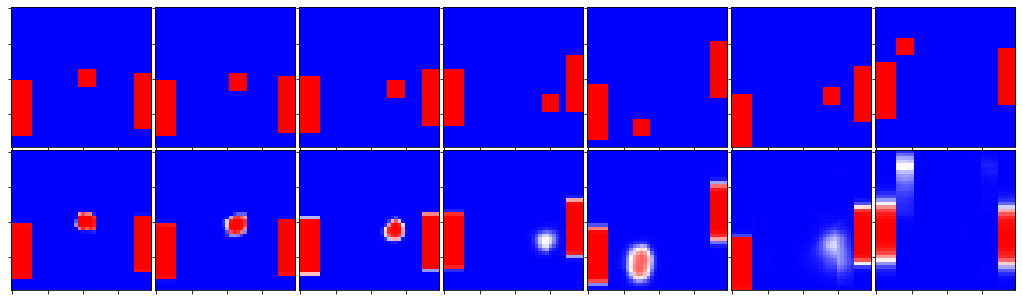

Epoch 143/2500
100/100 [==============================] - 83s 829ms/step - loss: 0.0539 - mean_squared_error: 0.0151 - acc: 0.9802 - val_loss: 0.0605 - val_mean_squared_error: 0.0172 - val_acc: 0.9772


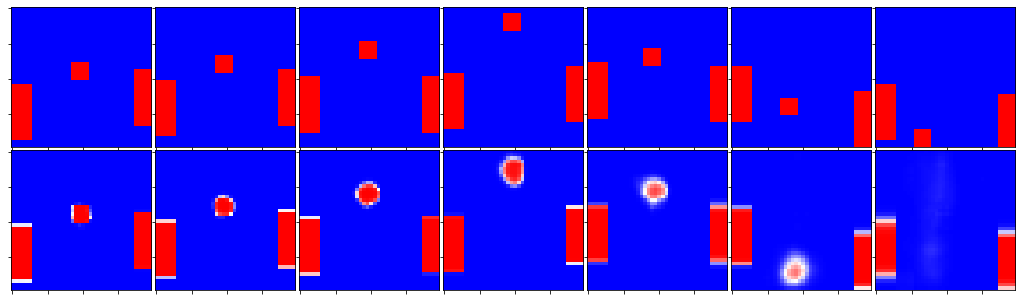

Epoch 144/2500
100/100 [==============================] - 83s 826ms/step - loss: 0.0520 - mean_squared_error: 0.0147 - acc: 0.9807 - val_loss: 0.0497 - val_mean_squared_error: 0.0144 - val_acc: 0.9810


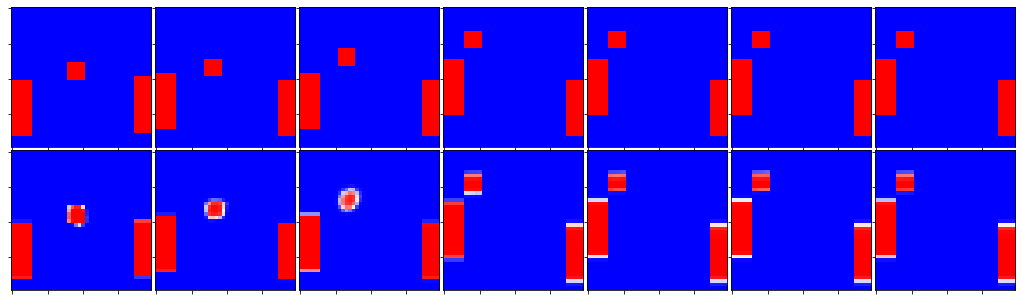

Epoch 145/2500
100/100 [==============================] - 83s 830ms/step - loss: 0.0535 - mean_squared_error: 0.0150 - acc: 0.9804 - val_loss: 0.0516 - val_mean_squared_error: 0.0146 - val_acc: 0.9805


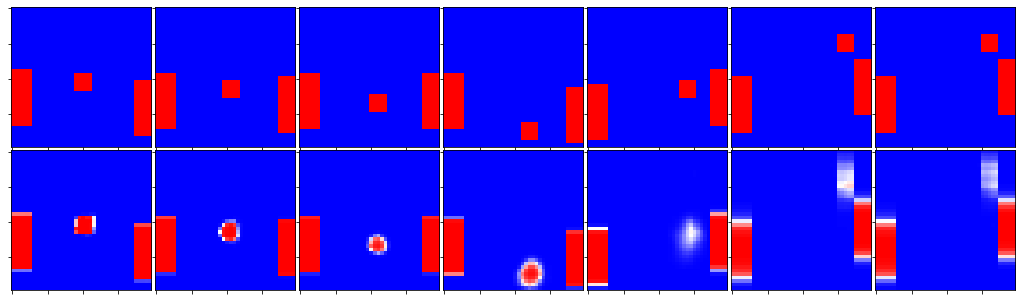

Epoch 146/2500
100/100 [==============================] - 84s 841ms/step - loss: 0.0597 - mean_squared_error: 0.0165 - acc: 0.9784 - val_loss: 0.0622 - val_mean_squared_error: 0.0174 - val_acc: 0.9770


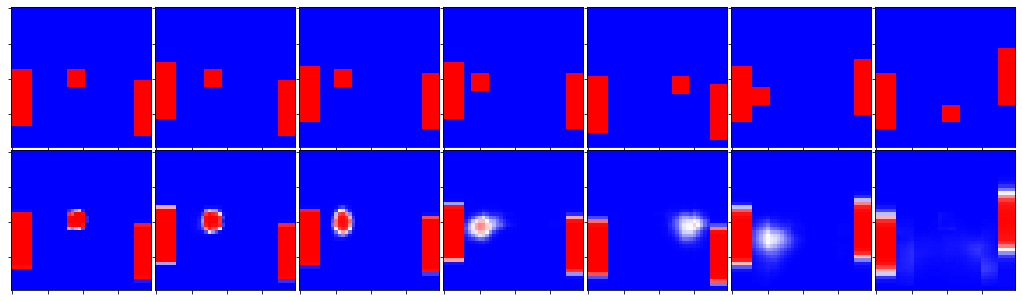

Epoch 147/2500
100/100 [==============================] - 84s 838ms/step - loss: 0.0520 - mean_squared_error: 0.0146 - acc: 0.9808 - val_loss: 0.0567 - val_mean_squared_error: 0.0160 - val_acc: 0.9791


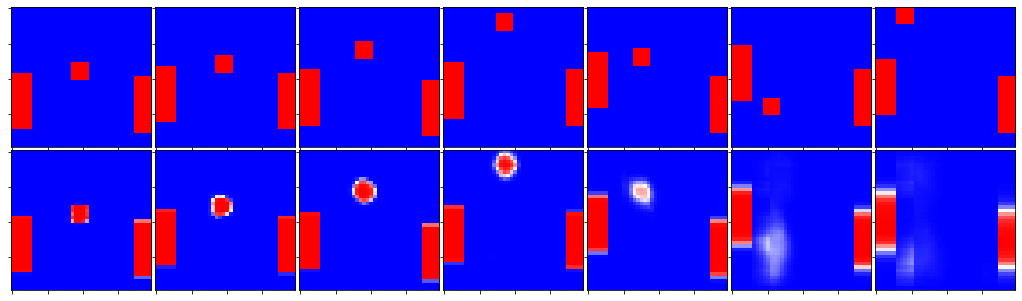

Epoch 148/2500
100/100 [==============================] - 83s 833ms/step - loss: 0.0517 - mean_squared_error: 0.0146 - acc: 0.9808 - val_loss: 0.0507 - val_mean_squared_error: 0.0143 - val_acc: 0.9811


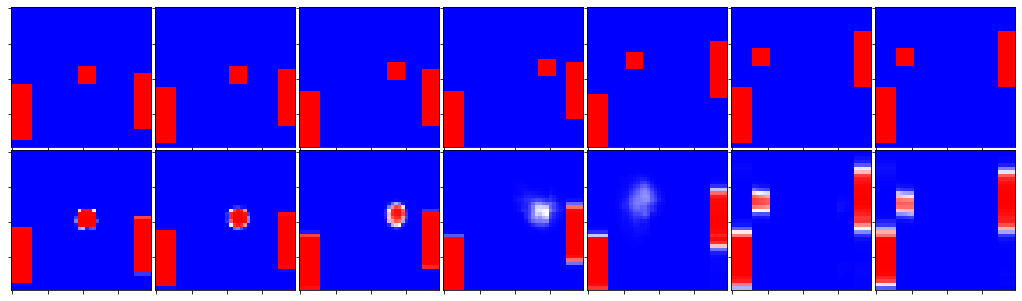

Epoch 149/2500
 23/100 [=====>........................] - ETA: 1:05 - loss: 0.0517 - mean_squared_error: 0.0145 - acc: 0.9810

In [ ]:
input_generator = make_dataset(bs=48)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=2500,
    callbacks=[PlotCallback()]
)

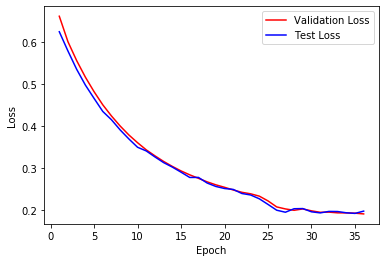

In [92]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# stateful = model.copy_in_stateful_model()
# stateful.init(0.4)
# t = 0
# 
# stateful.net.save('04-LSTM-GRU-32-BINARY_CROSSENTROPY_VERIED_INPUT.hdf5')

In [ ]:
# t += 1
# frame, _ = stateful.single_step_predict([-1, 1])

# plt.imshow(frame > 0.01)
# t